# Crash Reporting US | Exploratory Analysis
Goal: describe the most common conditions and patterns present in crash records and explore how factors relate to crash severity.


## 1. Introduction
### 1.1 Context for readers
Traffic crashes are a major public safety issue that lead to injuries, fatalities, and economic losses.

### 1.2 Motivation
Understanding common crash environments and driver/vehicle factors can inform safety awareness and policy discussions.

### 1.3 Research questions
1) Accident hotspots: which road types appear most often in crash records?
2) Time patterns: when do crashes occur most frequently?
3) Collision causes: what driver/vehicle factors are most common in crashes?
4) Environmental impacts: how do weather, surface, light, and traffic control relate to severity?
5) Vehicle conditions: do vehicle age and size show different damage patterns?


## 2. Data
### 2.1 Technical description
Dataset: ?Crash Reporting - Drivers Data? (Montgomery County, MD; ACRS system).
We use the CSV file provided with the project.


In [85]:
import pandas as pd
import numpy as np

df = pd.read_csv("crash_data.csv", encoding="latin1", low_memory=False)
df.head(3)


,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Off-Road Description,...,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Equipment Problems,Latitude,Longitude,Location
0,MCP3170003V,240000438,Montgomery County Police,Property Damage Crash,01/03/2024 14:55,NaN,NaN,NaN,NaN,IN FRONT OF 18900 BIRDSEYE DR,...,0,No,No,2017,LEXUS,SUV,NO MISUSE,39.165005,-77.249310,"(39.16500483, -77.24931)"
1,MCP3254003K,230072050,Montgomery County Police,Injury Crash,12/16/2023 12:36:00 PM,Maryland (State),GERMANTOWN RD,County,MIDDLEBROOK RD,NaN,...,35,No,No,2010,TOYT,PRIUS,NO MISUSE,39.178776,-77.267190,"(39.17877577, -77.26718974)"
2,EJ7887003Q,230074270,Gaithersburg Police Depar,Injury Crash,12/29/2023 12:00:00 PM,Maryland (State),GREAT SENECA HWY,Municipality,KENTLANDS BLVD,NaN,...,35,No,No,2021,SUBARU,FORRESTER,NO MISUSE,39.123574,-77.231769,"(39.12357374, -77.231769)"


In [86]:
# Dataset overview
overview = pd.DataFrame({
    "n_rows": [len(df)],
    "n_cols": [df.shape[1]],
    "n_numeric": [df.select_dtypes(include=["number"]).shape[1]],
    "n_categorical": [df.select_dtypes(include=["object"]).shape[1]],
})
overview


,n_rows,n_cols,n_numeric,n_categorical
0,167330,41,4,37


### 2.2 Research plan
We structure the analysis around five questions, linking each to relevant variables and outcomes.


In [87]:
plan = pd.DataFrame({
    "No.": [1,2,3,4,5],
    "Research Question": [
        "Accident hotspots",
        "Time patterns",
        "Collision causes",
        "Environmental impacts",
        "Vehicle conditions"
    ],
    "Key Variables": [
        "Route Type, Cross-Street Type",
        "Crash Date/Time",
        "Driver Substance Abuse, Driver Distracted By, Vehicle Movement, Equipment Problems",
        "Weather, Surface Condition, Light, Traffic Control, Speed Limit",
        "Vehicle Year, Vehicle Body Type"
    ],
    "Outcomes": [
        "N/A",
        "N/A",
        "Vehicle Damage Extent",
        "Injury Severity, Vehicle Damage Extent",
        "Vehicle Damage Extent"
    ]
})
plan


,No.,Research Question,Key Variables,Outcomes
0,1,Accident hotspots,"Route Type, Cross-Street Type",N/A
1,2,Time patterns,Crash Date/Time,N/A
2,3,Collision causes,"Driver Substance Abuse, Driver Distracted By, ...",Vehicle Damage Extent
3,4,Environmental impacts,"Weather, Surface Condition, Light, Traffic Con...","Injury Severity, Vehicle Damage Extent"
4,5,Vehicle conditions,"Vehicle Year, Vehicle Body Type",Vehicle Damage Extent


### 2.3 Data preparation and missing values
- Remove full-row duplicates.
- Drop identifiers and highly-missing or irrelevant fields.
- Convert crash time to datetime and derive time features.
- Clean abnormal Vehicle Year values (e.g., 0, 9999, future years).
- Treat missing categories as ?Missing/Unknown? for key categorical fields.


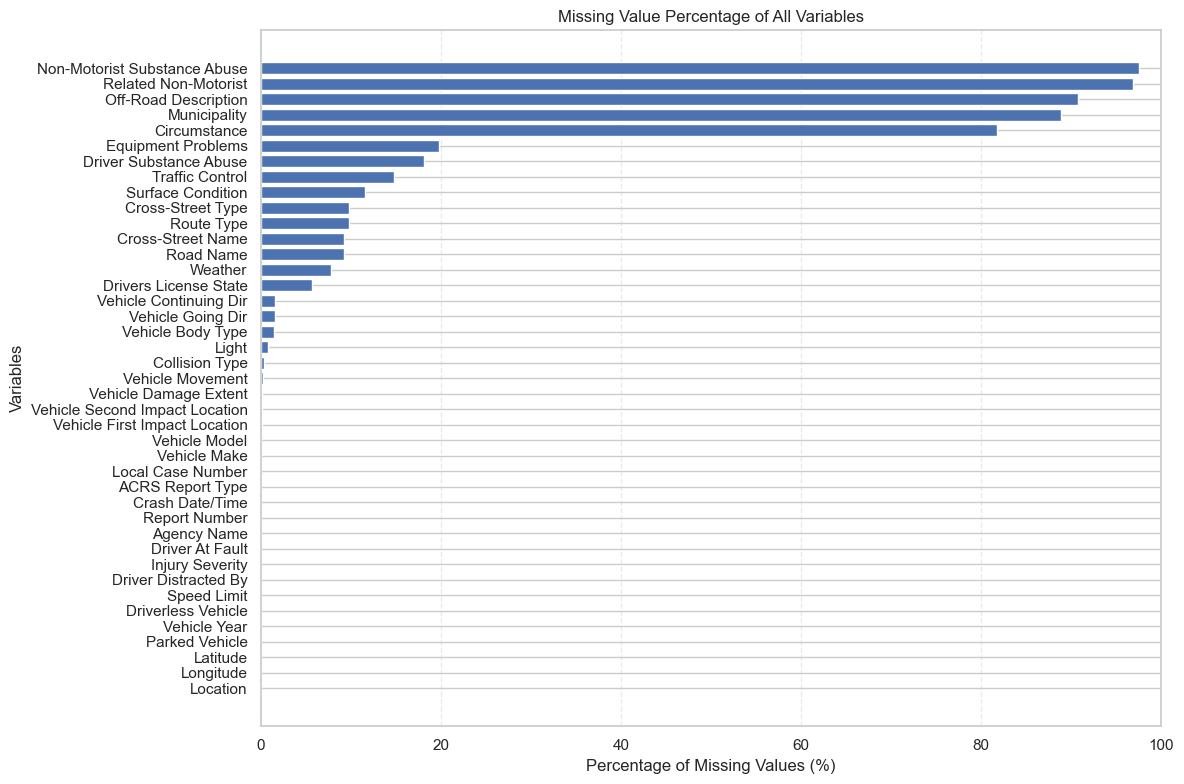

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1) Missing % per column
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)

# Optional: plot only columns with at least 1% missing
# missing_pct = missing_pct[missing_pct > 1]

# 2) Plot (horizontal bars)
plt.figure(figsize=(12, 8))
plt.barh(missing_pct.index, missing_pct.values)
plt.gca().invert_yaxis()  # largest on top

plt.title("Missing Value Percentage of All Variables")
plt.xlabel("Percentage of Missing Values (%)")
plt.ylabel("Variables")
plt.xlim(0, 100)

# Grid similar vibe to ggplot
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# # Missingness pattern (sample)
# sample = df.sample(500, random_state=42)
# plt.figure(figsize=(8,4))
# sns.heatmap(sample.isna(), cbar=False)
# plt.title("Missingness pattern (sample of 500 rows)")
# plt.xlabel("Variables")
# plt.ylabel("Rows")
# plt.tight_layout()
# plt.show()


In [89]:
# Remove exact duplicates
df = df.drop_duplicates()

# Drop identifiers and high-missing or irrelevant columns
drop_cols = [
    "Report Number", "Local Case Number", "Parked Vehicle", "Driverless Vehicle", "Driver At Fault",
    "Non-Motorist Substance Abuse", "Related Non-Motorist", "ACRS Report Type", "Agency Name", "Latitude", "Longitude",
    "Off-Road Description", "Municipality", "Circumstance", "Collision Type", "Drivers License State", "Vehicle Model",
    "Location", "Road Name", "Cross-Street Name", "Vehicle Going Dir", "Vehicle Continuing Dir" , "Vehicle First Impact Location" , "Vehicle Second Impact Location"
    
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Missing/Unknown for key categoricals
missing_as_category = [
    "Weather", "Surface Condition", "Light", "Traffic Control",
    "Driver Substance Abuse", "Driver Distracted By", "Equipment Problems",
    "Vehicle Movement", "Vehicle Body Type", "Vehicle Damage Extent",
    "Route Type", "Cross-Street Type", "Injury Severity"
]
for c in missing_as_category:
    if c in df.columns:
        df[c] = df[c].astype("object").fillna("Missing/Unknown")


overview_after = pd.DataFrame({
    "n_rows": [len(df)],
    "n_cols": [df.shape[1]],
    "n_numeric": [df.select_dtypes(include=["number"]).shape[1]],
    "n_categorical": [df.select_dtypes(include=["object"]).shape[1]],
})
overview_after

,n_rows,n_cols,n_numeric,n_categorical
0,167326,17,2,15


C:\Users\liorbj\AppData\Local\Temp\ipykernel_37148\1334882079.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  missing_pct_refined = (df.applymap(lambda x: x == "Missing/Unknown").mean() * 100).sort_values(ascending=False)


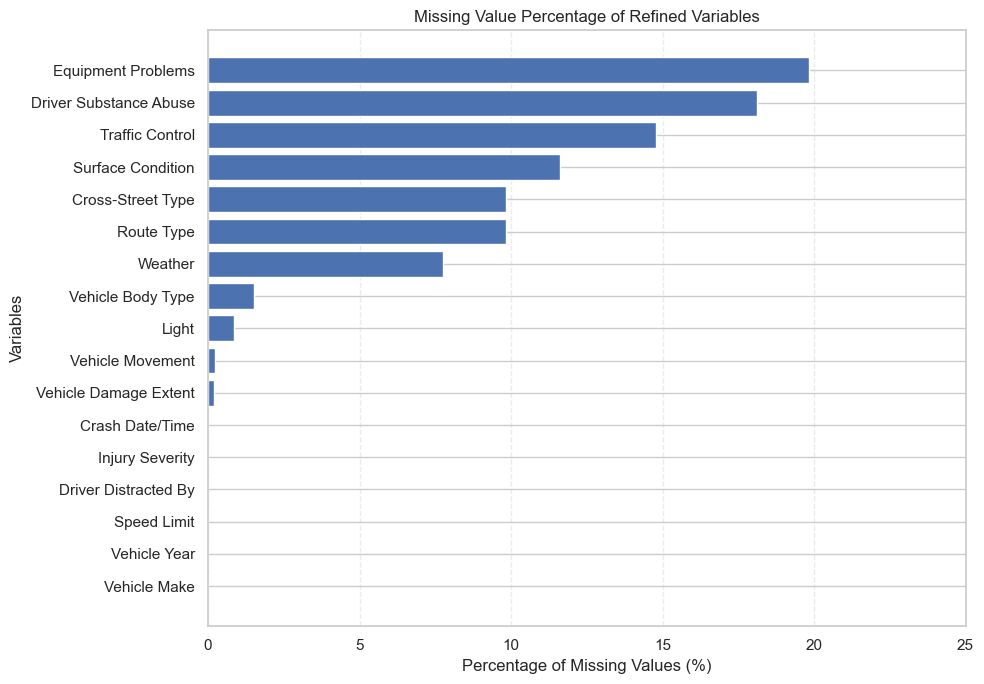

In [90]:
import matplotlib.pyplot as plt

missing_pct_refined = (df.applymap(lambda x: x == "Missing/Unknown").mean() * 100).sort_values(ascending=False)

plt.figure(figsize=(10, 7))
plt.barh(missing_pct_refined.index, missing_pct_refined.values)
plt.gca().invert_yaxis()

plt.title("Missing Value Percentage of Refined Variables")
plt.xlabel("Percentage of Missing Values (%)")
plt.ylabel("Variables")
plt.xlim(0, 25)  # matches your plot scale

plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


C:\Users\liorbj\AppData\Local\Temp\ipykernel_37148\2371908037.py:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  miss = df_s.applymap(lambda x: str(x).strip() == "Missing/Unknown")


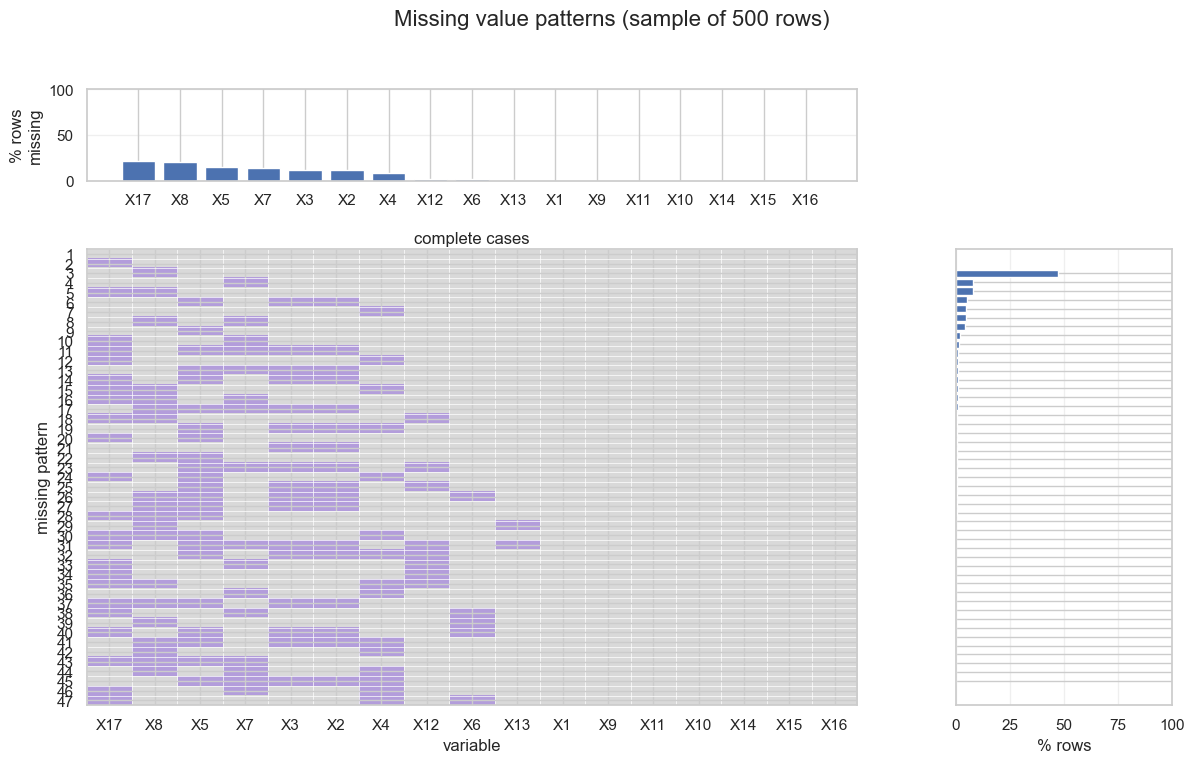

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

vars_order = [
    "Crash Date/Time",
    "Route Type",
    "Cross-Street Type",
    "Weather",
    "Surface Condition",
    "Light",
    "Traffic Control",
    "Driver Substance Abuse",
    "Injury Severity",
    "Driver Distracted By",
    "Vehicle Damage Extent",
    "Vehicle Body Type",
    "Vehicle Movement",
    "Speed Limit",
    "Vehicle Year",
    "Vehicle Make",
    "Equipment Problems",
]

var_to_num = {name: i + 1 for i, name in enumerate(vars_order)}

# ----------------------------
# Sample data
# ----------------------------
sample_n = 500
df_s = df[vars_order].sample(n=sample_n)

# Boolean missingness mask
miss = df_s.applymap(lambda x: str(x).strip() == "Missing/Unknown")

# ----------------------------
# 1) SORT VARIABLES by % missing
# ----------------------------
missing_pct = miss.mean(axis=0) * 100
missing_pct = missing_pct.sort_values(ascending=False)

vars_sorted = missing_pct.index.tolist()

# Reorder mask to match sorted variables
miss = miss[vars_sorted]

# ----------------------------
# 2) SORT MISSING PATTERNS by % rows
# ----------------------------
patterns = miss.apply(lambda r: tuple(r.values), axis=1)
pattern_counts = patterns.value_counts().sort_values(ascending=False)

pattern_matrix = np.array(pattern_counts.index.tolist(), dtype=bool)
pattern_freq_pct = (pattern_counts.values / len(df_s)) * 100

# ----------------------------
# 3) Plot
# ----------------------------
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(
    nrows=2, ncols=2,
    height_ratios=[1, 5],
    width_ratios=[5, 1.4],
    hspace=0.25, wspace=0.2
)

ax_top = fig.add_subplot(gs[0, 0])
ax_mid = fig.add_subplot(gs[1, 0])
ax_right = fig.add_subplot(gs[1, 1])

# ---- Top bar chart (sorted by % missing)
x = np.arange(len(vars_sorted))
ax_top.bar(x, missing_pct.values)
ax_top.set_ylim(0, 100)
ax_top.set_xticks(x)
ax_top.set_xticklabels([f"X{var_to_num[v]}" for v in vars_sorted])
ax_top.set_ylabel("% rows\nmissing")
ax_top.grid(axis="y", alpha=0.3)

# ---- Heatmap (aligned with sorted variables)
img = pattern_matrix.astype(int)
cmap = ListedColormap(["#d9d9d9", "#b39ddb"])

ax_mid.imshow(img, aspect="auto", interpolation="nearest", cmap=cmap)

ax_mid.set_xticks(x)
ax_mid.set_xticklabels([f"X{var_to_num[v]}" for v in vars_sorted])
ax_mid.set_yticks(np.arange(len(pattern_counts)))
ax_mid.set_yticklabels(np.arange(1, len(pattern_counts) + 1))
ax_mid.set_xlabel("variable")
ax_mid.set_ylabel("missing pattern")

ax_mid.text(
    0.5, 1.04, "complete cases",
    transform=ax_mid.transAxes,
    ha="center", va="top",
    fontsize=12
)

ax_mid.set_xticks(np.arange(-0.5, len(vars_sorted), 1), minor=True)
ax_mid.set_yticks(np.arange(-0.5, len(pattern_counts), 1), minor=True)
ax_mid.grid(which="minor", color="white", linewidth=0.5)
ax_mid.tick_params(which="minor", bottom=False, left=False)

# ---- Right bar chart (sorted by % rows)
y = np.arange(len(pattern_counts))
ax_right.barh(y, pattern_freq_pct)
ax_right.invert_yaxis()
ax_right.set_xlim(0, 100)
ax_right.set_xlabel("% rows")
ax_right.set_yticks(y)
ax_right.set_yticklabels([])
ax_right.grid(axis="x", alpha=0.3)

fig.suptitle("Missing value patterns (sample of 500 rows)", fontsize=16)
plt.show()


## 3. Results
### 3.1 Accident Hotspots


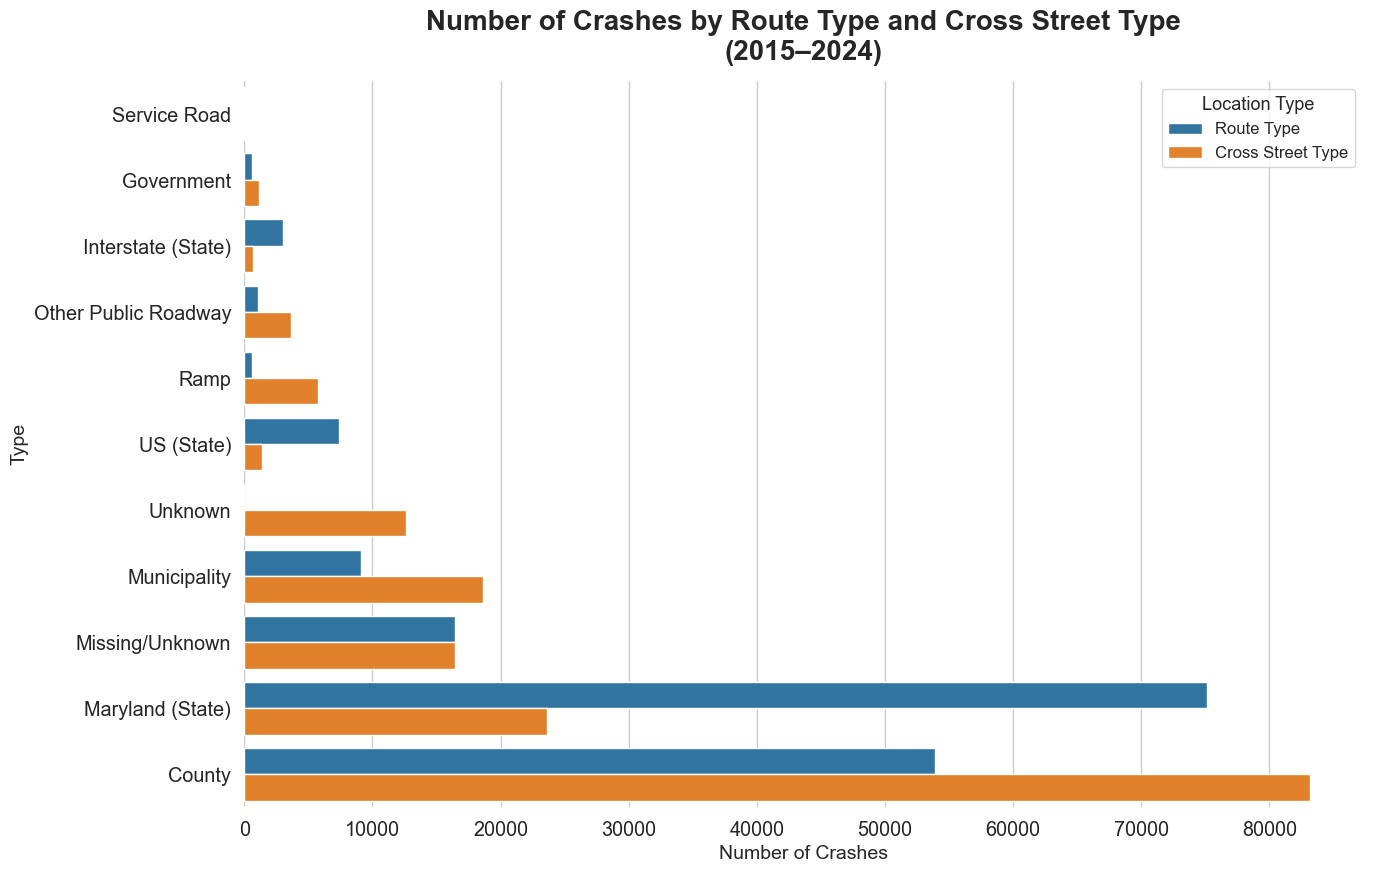

In [91]:

route_counts = (
    df["Route Type"]
    .value_counts()
    .reset_index()
)
route_counts.columns = ["type", "count"]
route_counts["location"] = "Route Type"

cross_counts = (
    df["Cross-Street Type"]
    .value_counts()
    .reset_index()
)
cross_counts.columns = ["type", "count"]
cross_counts["location"] = "Cross Street Type"

plot_df = pd.concat([route_counts, cross_counts], ignore_index=True)


plot_df["type"] = pd.Categorical(
    plot_df["type"],
    categories=plot_df.groupby("type")["count"].sum().sort_values().index,
    ordered=True
)


sns.set_theme(style="whitegrid", font_scale=1.3)

plt.figure(figsize=(14, 9))

palette = {
    "Route Type": "#1f77b4",        # blue
    "Cross Street Type": "#ff7f0e"  # orange
}

ax = sns.barplot(
    data=plot_df,
    x="count",
    y="type",
    hue="location",
    palette=palette
)

ax.set_title(
    "Number of Crashes by Route Type and Cross Street Type\n(2015–2024)",
    fontsize=20,
    weight="bold",
    pad=15
)
ax.set_xlabel("Number of Crashes", fontsize=14)
ax.set_ylabel("Type", fontsize=14)

ax.legend(title="Location Type", fontsize=12, title_fontsize=13)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()



### 3.2 Time Patterns
#### 3.2.1 Yearly & Seasonal Patterns


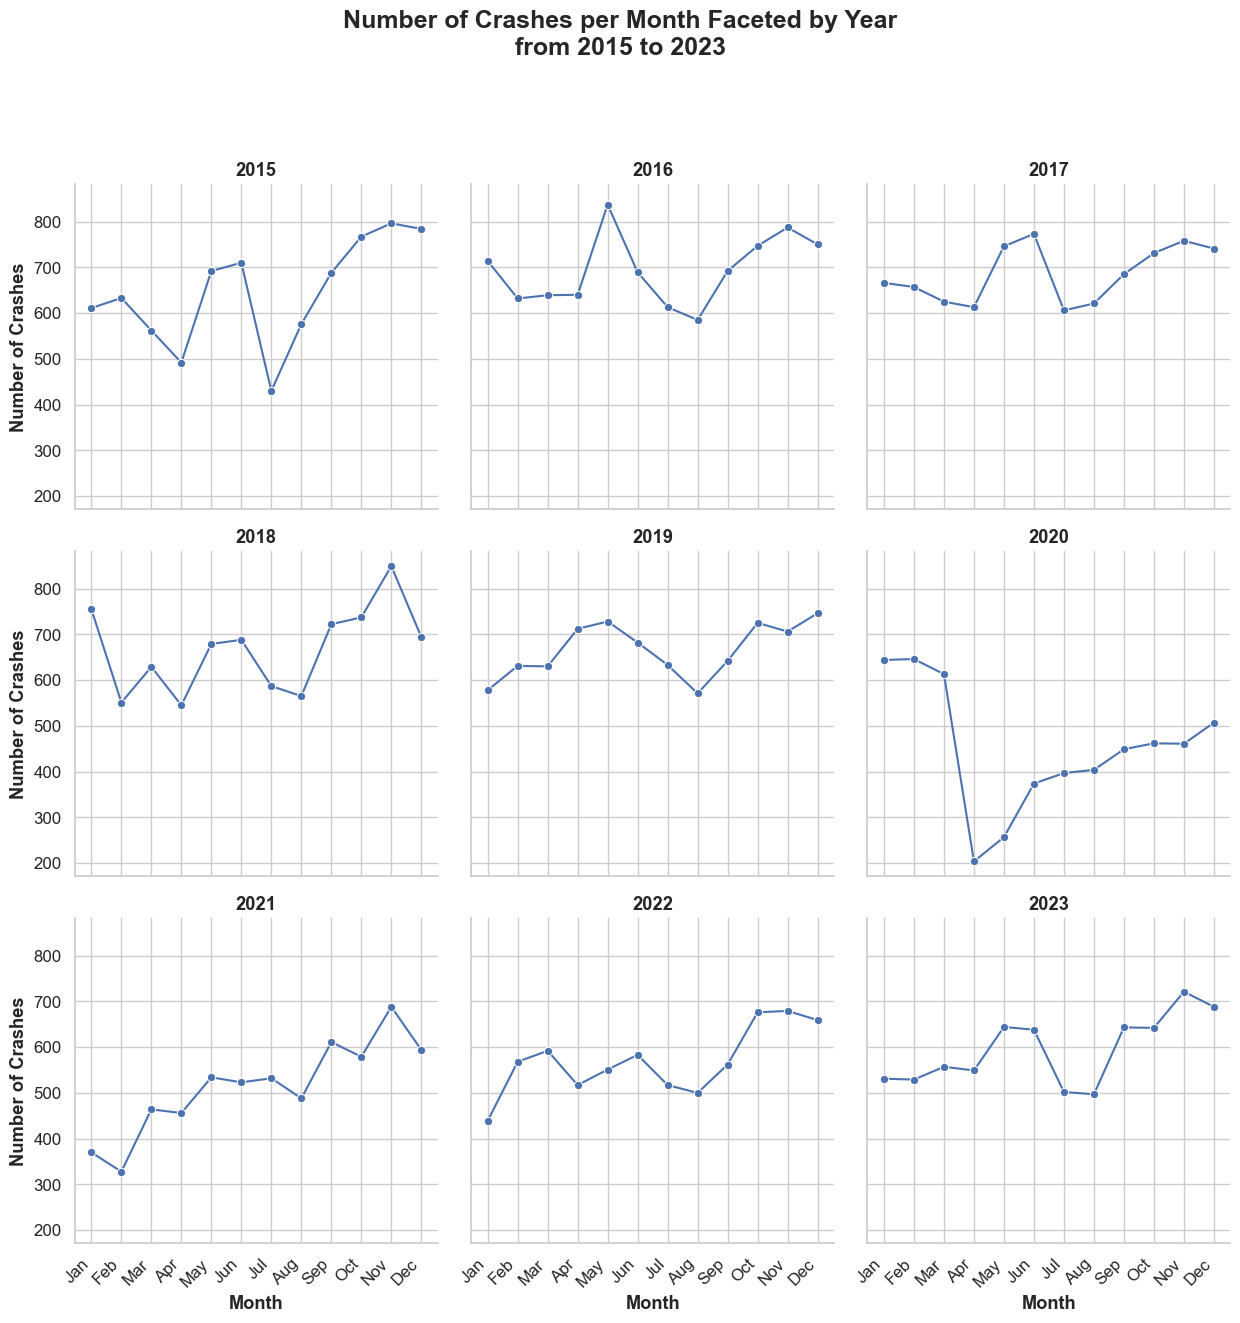

In [112]:

DATE_COL = "Crash Date/Time"
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

# Keep only rows with valid dates
df = df.dropna(subset=[DATE_COL])

# ----------------------------
# Extract Year + Month
# ----------------------------
df["Year"] = df[DATE_COL].dt.year
df["Month"] = df[DATE_COL].dt.month

# Filter to 2015–2023 (change if needed)
df = df[(df["Year"] >= 2015) & (df["Year"] <= 2023)]

# ----------------------------
# Count crashes per (Year, Month)
# ----------------------------
monthly_counts = (
    df.groupby(["Year", "Month"])
      .size()
      .reset_index(name="Crashes")
)

# Ensure months are ordered 1..12 and include missing months as zeros
all_years = sorted(monthly_counts["Year"].unique())
full_index = pd.MultiIndex.from_product([all_years, range(1, 13)], names=["Year", "Month"])
monthly_counts = (
    monthly_counts.set_index(["Year", "Month"])
                  .reindex(full_index, fill_value=0)
                  .reset_index()
)

# Month labels
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# ----------------------------
# Plot: Faceted line chart by year
# ----------------------------
sns.set_theme(style="whitegrid", font_scale=1.1)

g = sns.FacetGrid(
    monthly_counts,
    col="Year",
    col_wrap=3,        # 9 panels per row (2015–2023 fits nicely)
    height=4.2,
    sharey=True
)

g.map_dataframe(
    sns.lineplot,
    x="Month",
    y="Crashes",
    marker="o",
    linewidth=1.5
)

# Axis formatting
g.set_axis_labels("Month", "Number of Crashes")
g.set_titles(col_template="{col_name}")

for ax in g.axes.flat:
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_labels, rotation=45, ha="right")

# Title
g.fig.suptitle(
    "Number of Crashes per Month Faceted by Year\nfrom 2015 to 2023",
    fontsize=18,
    weight="bold",
    y=1.05
)

plt.tight_layout()
plt.show()


#### 3.2.2 Weekly & Time Patterns


C:\Users\liorbj\AppData\Local\Temp\ipykernel_37148\2007432167.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["WeekdayName", "Hour"])


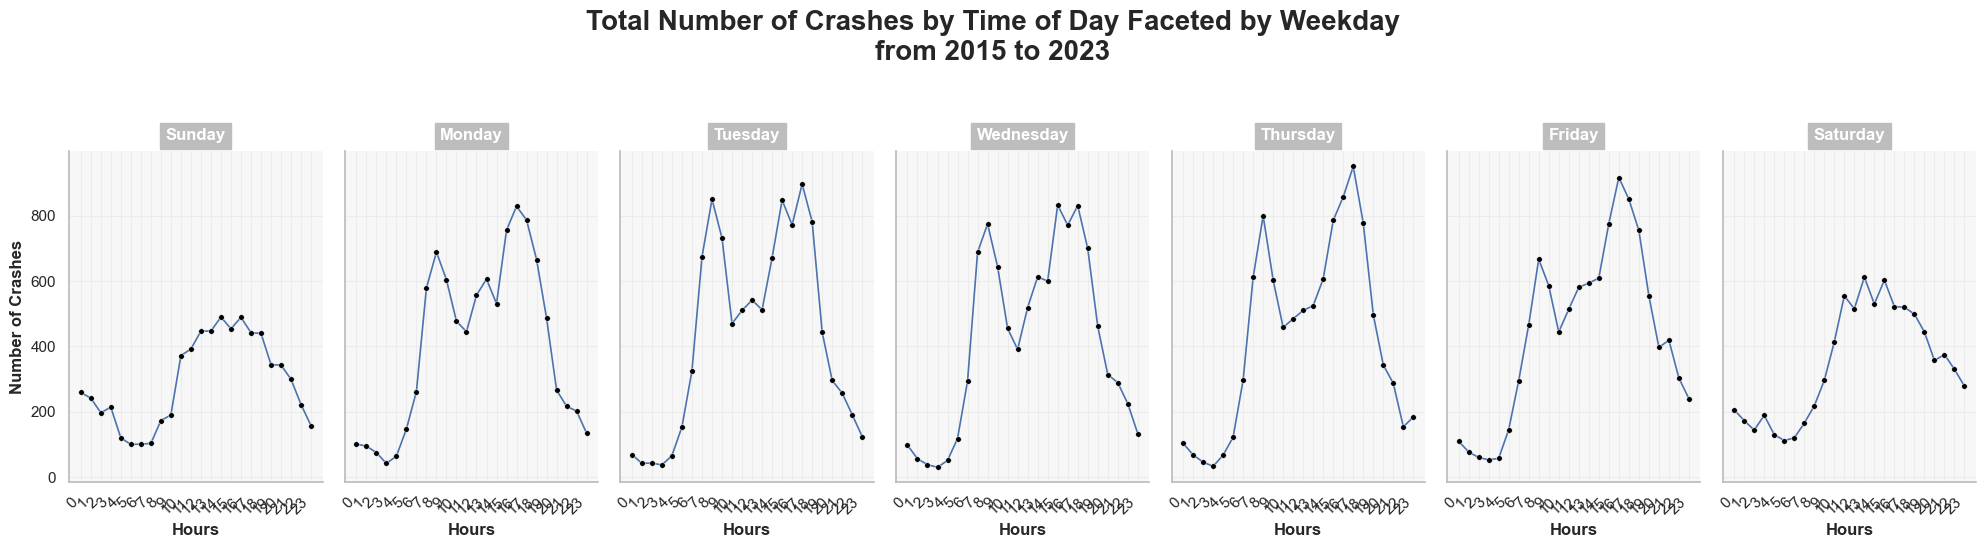

In [117]:

DATE_COL = "Crash Date/Time"  # change if needed
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.dropna(subset=[DATE_COL])

# Filter years (2015–2023)
df["Year"] = df[DATE_COL].dt.year
df = df[(df["Year"] >= 2015) & (df["Year"] <= 2023)]

# ----------------------------
# Extract hour + weekday
# ----------------------------
df["Hour"] = df[DATE_COL].dt.hour

# Pandas: Monday=0 ... Sunday=6
df["Weekday"] = df[DATE_COL].dt.dayofweek

weekday_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
weekday_map = {6: "Sunday", 0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday"}

df["WeekdayName"] = df["Weekday"].map(weekday_map)
df["WeekdayName"] = pd.Categorical(df["WeekdayName"], categories=weekday_order, ordered=True)

# ----------------------------
# Count crashes by (weekday, hour)
# ----------------------------
hourly_weekday = (
    df.groupby(["WeekdayName", "Hour"])
      .size()
      .reset_index(name="Crashes")
)

# Fill missing hour bins (0..23) for each weekday with zero
full_index = pd.MultiIndex.from_product([weekday_order, range(24)], names=["WeekdayName", "Hour"])
hourly_weekday = (
    hourly_weekday.set_index(["WeekdayName", "Hour"])
                 .reindex(full_index, fill_value=0)
                 .reset_index()
)

# ----------------------------
# Plot (ggplot-like, faceted by weekday)
# ----------------------------
sns.set_theme(
    style="whitegrid",
    rc={
        "axes.facecolor": "#f7f7f7",
        "grid.color": "#e6e6e6",
        "grid.linewidth": 0.8,
        "axes.edgecolor": "#bdbdbd",
        "axes.labelweight": "bold",
        "axes.titleweight": "bold",
    }
)

g = sns.FacetGrid(
    hourly_weekday,
    col="WeekdayName",
    col_wrap=7,     # one row like your example
    height=5.2,
    aspect=0.55,
    sharey=True
)

# Line + black points
g.map_dataframe(
    sns.lineplot,
    x="Hour",
    y="Crashes",
    color="#4C72B0",
    linewidth=1.2
)

g.map_dataframe(
    sns.scatterplot,
    x="Hour",
    y="Crashes",
    color="black",
    s=16,
    zorder=3
)

# Axis labels/ticks
g.set_axis_labels("Hours", "Number of Crashes")
g.set_titles(col_template="{col_name}")

for ax in g.axes.flat:
    ax.set_xticks(range(24))
    ax.set_xticklabels([str(h) for h in range(24)], rotation=45, ha="right")
    ax.grid(True, axis="both", alpha=0.6)

# Grey facet headers like ggplot
for ax in g.axes.flat:
    ax.set_title(
        ax.get_title(),
        backgroundcolor="#bdbdbd",
        color="white",
        fontsize=12,
        pad=8
    )

g.fig.suptitle(
    "Total Number of Crashes by Time of Day Faceted by Weekday\nfrom 2015 to 2023",
    fontsize=20,
    weight="bold",
    y=1.05
)

plt.tight_layout()
plt.show()

### 3.3 Collision Causes
#### 3.3.1 Driver Substance Abuse


In [118]:
substance_pct = df["Driver Substance Abuse"].value_counts(normalize=True).mul(100).round(2)
substance_pct


Driver Substance Abuse
NONE DETECTED                 71.79
Missing/Unknown               17.89
UNKNOWN                        6.70
ALCOHOL PRESENT                2.34
ALCOHOL CONTRIBUTED            0.83
ILLEGAL DRUG PRESENT           0.17
MEDICATION PRESENT             0.07
ILLEGAL DRUG CONTRIBUTED       0.06
COMBINED SUBSTANCE PRESENT     0.06
MEDICATION CONTRIBUTED         0.04
COMBINATION CONTRIBUTED        0.03
OTHER                          0.02
Name: proportion, dtype: float64

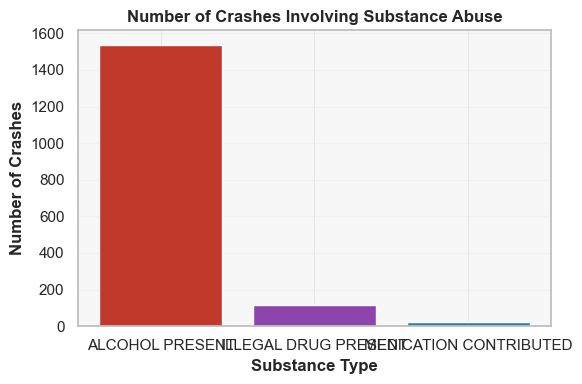

In [136]:
substance_df = df[df["Driver Substance Abuse"].isin(
    ["ALCOHOL PRESENT" , "ILLEGAL DRUG PRESENT" , "MEDICATION CONTRIBUTED" ]
)]

# Count crashes by substance type
counts = substance_df["Driver Substance Abuse"].value_counts()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(
    counts.index,
    counts.values,
    color=["#c0392b", "#8e44ad", "#2980b9"]
)

plt.title("Number of Crashes Involving Substance Abuse")
plt.xlabel("Substance Type")
plt.ylabel("Number of Crashes")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


#### 3.3.2 Driver Distraction


In [137]:
# Group distraction into broader categories
def categorize_distraction(val):
    v = str(val).lower()
    if "not distracted" in v:
        return "Not Distracted"
    if "inattention" in v or "looked but did not see" in v:
        return "Inattention"
    if "phone" in v or "text" in v or "cell" in v or "other occupants" in v or "inside" in v:
        return "Internal Distraction"
    if "outside" in v or "external" in v or "pedestrian" in v or "object" in v:
        return "External Distraction"
    return "Other"

df["Distraction Group"] = df["Driver Distracted By"].apply(categorize_distraction)
distract_pct = df["Distraction Group"].value_counts(normalize=True).mul(100).round(2)
distract_pct


Distraction Group
Not Distracted          62.47
Other                   23.59
Inattention             12.50
External Distraction     0.75
Internal Distraction     0.69
Name: proportion, dtype: float64

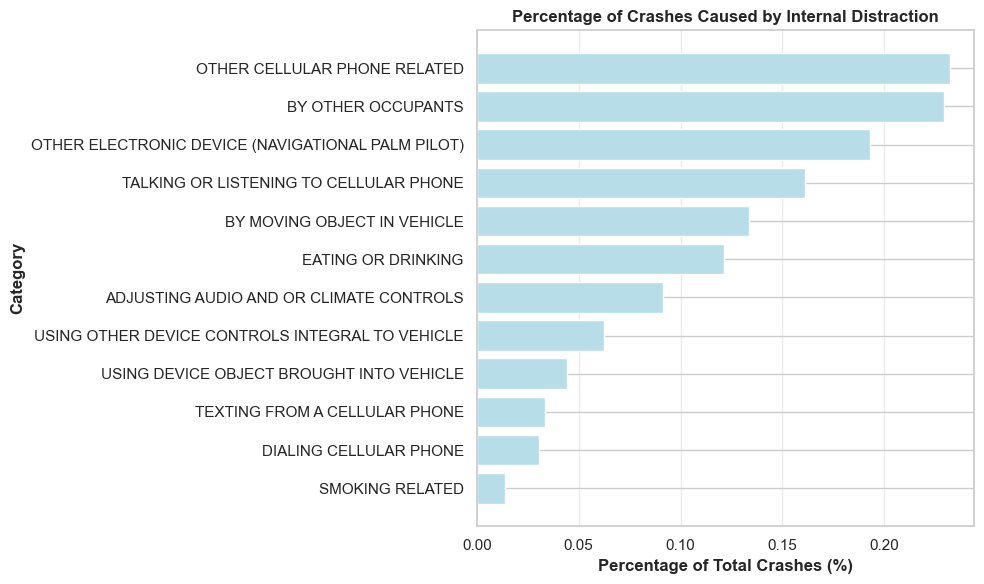

In [158]:
internal_categories = [
    "BY OTHER OCCUPANTS",
    "OTHER CELLULAR PHONE RELATED",
    "OTHER ELECTRONIC DEVICE (NAVIGATIONAL PALM PILOT)",
    "TALKING OR LISTENING TO CELLULAR PHONE",
    "BY MOVING OBJECT IN VEHICLE",
    "EATING OR DRINKING",
    "ADJUSTING AUDIO AND OR CLIMATE CONTROLS",
    "USING OTHER DEVICE CONTROLS INTEGRAL TO VEHICLE",
    "TEXTING FROM A CELLULAR PHONE",
    "USING DEVICE OBJECT BROUGHT INTO VEHICLE",
    "DIALING CELLULAR PHONE",
    "SMOKING RELATED"
]

# ----------------------------
# Filter internal distractions
# ----------------------------
internal_df = df[df["Driver Distracted By"].isin(internal_categories)]

# ----------------------------
# Compute percentage of total crashes
# ----------------------------
total_crashes = len(df)

percentages = (
    internal_df["Driver Distracted By"]
    .value_counts()
    / total_crashes
    * 100
)

percentages = percentages.sort_values(ascending=True)

# ----------------------------
# Plot
# ----------------------------
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.barh(
    percentages.index,
    percentages.values,
    color="#b7dde8"
)

plt.title("Percentage of Crashes Caused by Internal Distraction", fontsize=12, weight="bold")
plt.xlabel("Percentage of Total Crashes (%)", fontsize=12)
plt.ylabel("Category", fontsize=12)

plt.grid(axis="x", alpha=0.4)
plt.tight_layout()
plt.show()

#### 3.3.3 Vehicle Equipment Problems


In [138]:
equip_pct = df["Equipment Problems"].value_counts(normalize=True).mul(100).round(2)
equip_pct


Equipment Problems
NO MISUSE              72.16
Missing/Unknown        19.72
UNKNOWN                 7.94
AIR BAG FAILED          0.11
OTHER                   0.05
BELT(S) MISUSED         0.02
STRAP/TETHER LOOSE      0.01
BELTS/ANCHORS BROKE     0.00
SIZE/TYPE IMPROPER      0.00
NOT STREPPED RIGHT      0.00
FACING WRONG WAY        0.00
Name: proportion, dtype: float64

#### 3.3.4 Vehicle Movement (vs Vehicle Damage Extent)


In [139]:
# Collapse vehicle movement into broader categories
def movement_group(v):
    s = str(v).lower()
    if "park" in s or "stopped" in s or "stationary" in s:
        return "Stationary"
    if "turn" in s or "u turn" in s or "lane" in s:
        return "Turning"
    if "start" in s:
        return "Starting"
    if "traffic" in s or "enter" in s or "leave" in s:
        return "Traffic"
    if "skid" in s or "slow" in s or "stop" in s or "pass" in s:
        return "Maneuvering"
    return "In Motion"

df["Movement Group"] = df["Vehicle Movement"].apply(movement_group)
movement_damage = pd.crosstab(df["Movement Group"], df["Vehicle Damage Extent"], normalize="index")
movement_damage.round(3)


Vehicle Damage Extent,DESTROYED,DISABLING,FUNCTIONAL,Missing/Unknown,NO DAMAGE,OTHER,SUPERFICIAL,UNKNOWN
Movement Group,,,,,,,,
In Motion,0.063,0.438,0.220,0.002,0.030,0.001,0.198,0.048
Maneuvering,0.019,0.273,0.338,0.002,0.036,0.000,0.315,0.018
Stationary,0.009,0.152,0.343,0.002,0.042,0.001,0.428,0.025
Turning,0.038,0.392,0.260,0.001,0.052,0.000,0.224,0.033


### 3.4 Environmental Impact
#### 3.4.1 Weather Condition and Surface Condition


In [140]:
# Group weather and surface condition
def weather_group(v):
    s = str(v).lower()
    if any(k in s for k in ["rain", "snow", "fog", "sleet", "ice", "adverse"]):
        return "Adverse"
    return "Clear"

def surface_group(v):
    s = str(v).lower()
    if "dry" in s:
        return "Dry"
    if "wet" in s:
        return "Wet"
    if "snow" in s or "ice" in s:
        return "Snow/Ice"
    return "Other"

df["Weather Group"] = df["Weather"].apply(weather_group)
df["Surface Group"] = df["Surface Condition"].apply(surface_group)

ws_damage = pd.crosstab([df["Weather Group"], df["Surface Group"]], df["Vehicle Damage Extent"], normalize="index")
ws_damage.round(3).head(10)


Vehicle Damage Extent        DESTROYED  DISABLING  FUNCTIONAL  \
Weather Group Surface Group                                     
Adverse       Dry                0.011      0.460       0.253   
              Other              0.014      0.209       0.225   
              Snow/Ice           0.039      0.324       0.295   
              Wet                0.047      0.424       0.265   
Clear         Dry                0.047      0.380       0.267   
              Other              0.014      0.162       0.241   
              Snow/Ice           0.044      0.444       0.272   
              Wet                0.057      0.431       0.266   

Vehicle Damage Extent        Missing/Unknown  NO DAMAGE  OTHER  SUPERFICIAL  \
Weather Group Surface Group                                                   
Adverse       Dry                      0.000      0.011  0.000        0.241   
              Other                    0.006      0.094  0.000        0.376   
              Snow/Ice                 0.003      0.078  0.003        0.238   
              Wet                      0.001      0.027  0.000        0.211   
Clear         Dry                      0.001      0.032  0.001        0.243   
              Other                    0.005      0.076  0.001        0.393   
              Snow/Ice                 0.000      0.047  0.000        0.176   
              Wet                      0.001      0.026  0.001        0.197   

Vehicle Damage Extent        UNKNOWN  
Weather Group Surface Group           
Adverse       Dry              0.023  
              Other            0.076  
              Snow/Ice         0.021  
              Wet              0.025  
Clear         Dry              0.028  
              Other            0.109  
              Snow/Ice         0.017  
              Wet              0.022

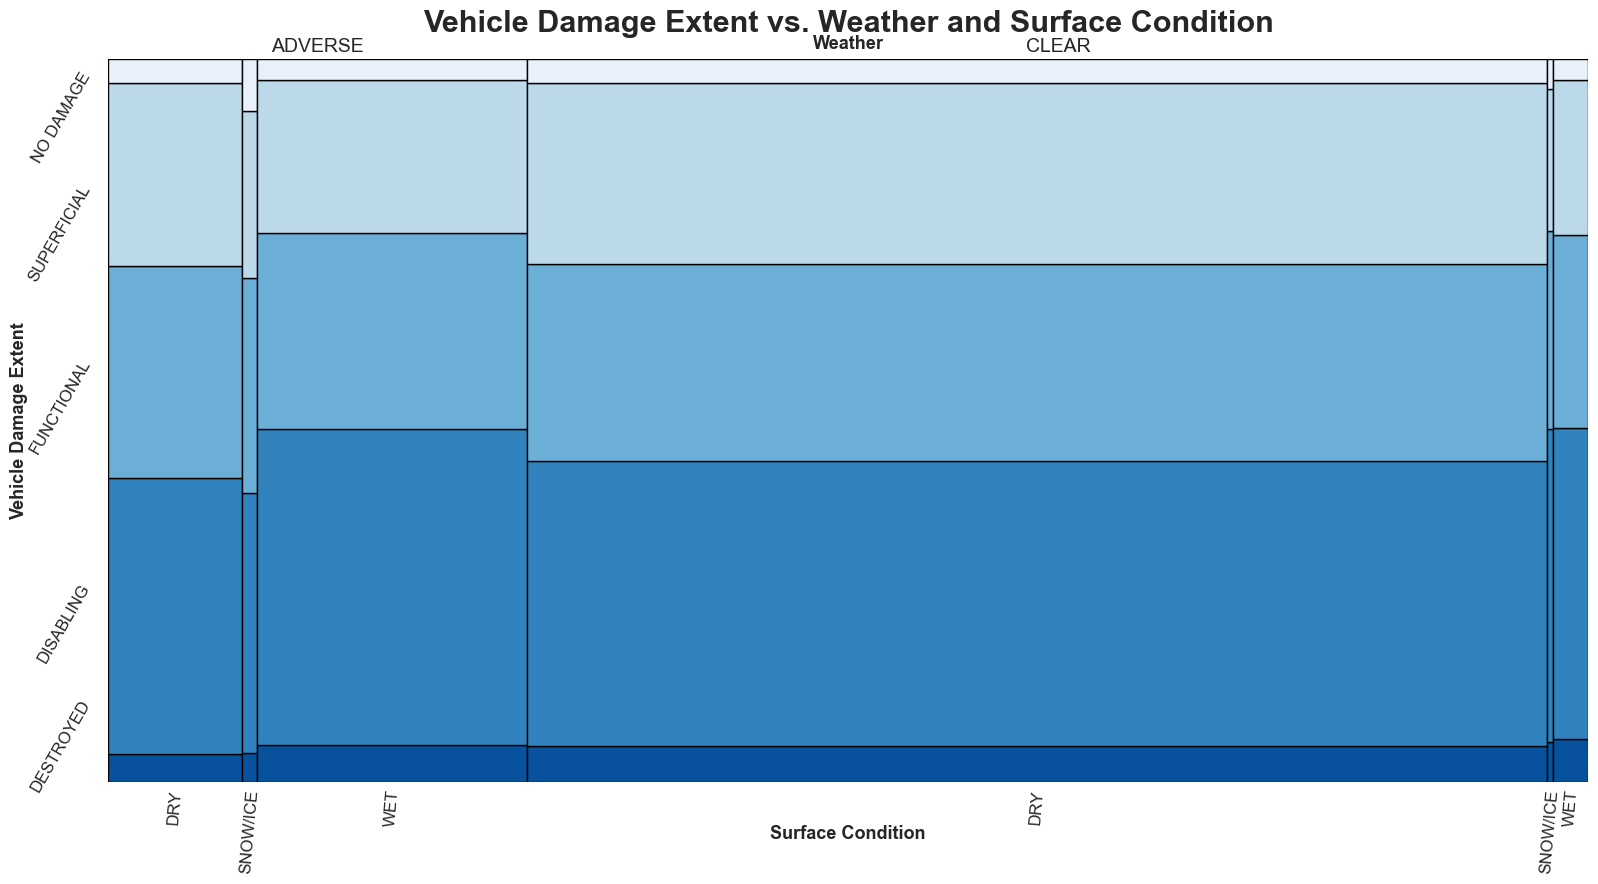

In [217]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

COL_W = "Weather"
COL_S = "Surface Condition"
COL_D = "Vehicle Damage Extent"

d = df[[COL_W, COL_S, COL_D]].copy()

# ----------------------------
# 2) Clean values
# ----------------------------
def normalize(x):
    if pd.isna(x):
        return pd.NA
    s = str(x).strip().upper()
    if s in {"UNKNOWN", "MISSING/UNKNOWN", "OTHER", "N/A", "NA", ""}:
        return pd.NA
    return s

for c in [COL_W, COL_S, COL_D]:
    d[c] = d[c].apply(normalize)

d = d.dropna(subset=[COL_W, COL_S, COL_D])

# ----------------------------
# 3) Recode Weather and Surface
# ----------------------------
d["Weather2"] = d[COL_W].apply(lambda w: "CLEAR" if w == "CLEAR" else "ADVERSE")

def surface_group(s):
    s = str(s).upper()
    if "SNOW" in s or "ICE" in s:
        return "SNOW/ICE"
    if "WET" in s or "SLUSH" in s or "WATER" in s:
        return "WET"
    return "DRY"

d["Surface2"] = d[COL_S].apply(surface_group)

# Keep only the 5 real damage categories 
damage_order = ["DESTROYED", "DISABLING", "FUNCTIONAL", "SUPERFICIAL", "NO DAMAGE"]
d = d[d[COL_D].isin(damage_order)].copy()

# Order (to match your plot)
weather_order = ["ADVERSE", "CLEAR"]
surface_order = ["DRY", "SNOW/ICE", "WET"]

# ----------------------------
# 4) Build contingency table
# ----------------------------
# counts[w, s, dmg]
counts = (
    d.groupby(["Weather2", "Surface2", COL_D])
     .size()
     .reindex(pd.MultiIndex.from_product([weather_order, surface_order, damage_order],
                                         names=["Weather2", "Surface2", COL_D]),
              fill_value=0)
)

total = counts.sum()

# widths for Weather blocks (overall proportion)
weather_totals = counts.groupby(level=0).sum()
weather_width = {w: weather_totals[w] / total for w in weather_order}

# within each Weather: widths for Surface blocks (conditional proportion)
surface_width = {}
for w in weather_order:
    w_total = weather_totals[w]
    for s in surface_order:
        ws_total = counts.loc[(w, s)].sum()
        surface_width[(w, s)] = (ws_total / w_total) if w_total > 0 else 0

# within each (Weather, Surface): heights for Damage stacks (conditional proportion)
damage_height = {}
for w in weather_order:
    for s in surface_order:
        ws_total = counts.loc[(w, s)].sum()
        for dmg in damage_order:
            c = counts.loc[(w, s, dmg)]
            damage_height[(w, s, dmg)] = (c / ws_total) if ws_total > 0 else 0

# ----------------------------
# 5) Colors (blue gradient like your example)
# ----------------------------
colors = {
    "NO DAMAGE":   "#e8f1fa",
    "SUPERFICIAL": "#bcd9ea",
    "FUNCTIONAL":  "#6baed6",
    "DISABLING":   "#3182bd",
    "DESTROYED":   "#08519c",
}

# ----------------------------
# 6) Draw mosaic manually
# ----------------------------
fig, ax = plt.subplots(figsize=(16, 9))

x0 = 0.0
weather_bounds = {}   # store for labeling top
surface_centers = {}  # store for bottom labels

for w in weather_order:
    w_w = weather_width[w]
    x1 = x0 + w_w
    weather_bounds[w] = (x0, x1)

    sx0 = x0
    for s in surface_order:
        s_w = w_w * surface_width[(w, s)]
        sx1 = sx0 + s_w

        # stack damage vertically inside this (w,s) rectangle
        y0 = 0.0
        for dmg in damage_order:  # bottom -> top
            h = damage_height[(w, s, dmg)]
            if h > 0:
                rect = Rectangle(
                    (sx0, y0), s_w, h,
                    facecolor=colors[dmg],
                    edgecolor="black",
                    linewidth=1
                )
                ax.add_patch(rect)
                y0 += h

        # center for surface label (only if this block exists)
        if s_w > 0:
            surface_centers[(w, s)] = (sx0 + sx1) / 2

        sx0 = sx1

    x0 = x1

# Axes formatting (clean like the R plot)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

# Title
ax.set_title("Vehicle Damage Extent vs. Weather and Surface Condition",
             fontsize=22, weight="bold", pad=20)

# Top Weather labels
ax.text(0.5, 1.01, "Weather", ha="center", va="bottom",
        transform=ax.transAxes, fontsize=13, weight="bold")

for w in weather_order:
    a, b = weather_bounds[w]
    ax.text((a + b) / 2, 1.005, w, ha="center", va="bottom",
            transform=ax.transAxes, fontsize=14)

# Bottom Surface labels
ax.text(0.5, -0.06, "Surface Condition", ha="center", va="top",
        transform=ax.transAxes, fontsize=13, weight="bold")

for w in weather_order:
    for s in surface_order:
        if (w, s) in surface_centers:
            ax.text(surface_centers[(w, s)], -0.01, s,
                    ha="center", va="top", rotation=85,
                    transform=ax.transAxes, fontsize=12)

# Left Damage labels (top -> bottom like your screenshot)
ax.text(-0.06, 0.5, "Vehicle Damage Extent",
        ha="center", va="center", rotation=90,
        transform=ax.transAxes, fontsize=13, weight="bold")

# Place labels at approximate band centers using global proportions
# (looks like the R plot and stays stable)
y_positions = {
    "NO DAMAGE":   0.92,
    "SUPERFICIAL": 0.76,
    "FUNCTIONAL":  0.52,
    "DISABLING":   0.22,
    "DESTROYED":   0.05
}
for dmg, yp in y_positions.items():
    ax.text(-0.01, yp, dmg, ha="right", va="center",
            rotation=60, transform=ax.transAxes, fontsize=12)

plt.tight_layout()
plt.show()


#### 3.4.2 Speed Limit (binned) vs Vehicle Damage Extent


In [159]:
# Speed limit bins with 55+
if "Speed Limit" in df.columns:
    def speed_bin(x):
        try:
            x = float(x)
        except Exception:
            return "Unknown"
        if x >= 55:
            return "55+"
        return str(int(x))
    df["Speed Bin"] = df["Speed Limit"].apply(speed_bin)
    speed_damage = pd.crosstab(df["Speed Bin"], df["Vehicle Damage Extent"], normalize="index")
speed_damage.round(3).head(10)


Vehicle Damage Extent,DESTROYED,DISABLING,FUNCTIONAL,Missing/Unknown,NO DAMAGE,OTHER,SUPERFICIAL,UNKNOWN
Speed Bin,,,,,,,,
0,0.007,0.114,0.258,0.004,0.095,0.002,0.434,0.086
10,0.006,0.119,0.239,0.003,0.087,0.001,0.435,0.109
15,0.007,0.158,0.247,0.002,0.076,0.000,0.404,0.105
20,0.020,0.286,0.256,0.004,0.064,0.002,0.302,0.066
25,0.034,0.328,0.245,0.002,0.061,0.000,0.284,0.044
30,0.045,0.394,0.266,0.002,0.037,0.001,0.225,0.030
35,0.042,0.382,0.274,0.002,0.026,0.001,0.246,0.028
40,0.059,0.422,0.272,0.002,0.018,0.001,0.206,0.021
45,0.061,0.434,0.262,0.001,0.018,0.001,0.207,0.017


#### 3.4.3 Light Condition and Traffic Control vs Injury Severity


In [ ]:
# Heatmaps by injury severity
injury_levels = df["Injury Severity"].value_counts().index[:4]
fig, axes = plt.subplots(2, 2, figsize=(10,8))
axes = axes.flatten()
for ax, level in zip(axes, injury_levels):
    sub = df[df["Injury Severity"] == level]
    ct = pd.crosstab(sub["Traffic Control"], sub["Light"], normalize="index")
    sns.heatmap(ct, ax=ax, cmap="Blues")
    ax.set_title(f"Injury: {level}")
    ax.set_xlabel("Light")
    ax.set_ylabel("Traffic Control")
plt.tight_layout()
plt.show()


#### 3.4.4 Chi-Square Tests


In [232]:
try:
    from scipy.stats import chi2_contingency
    tests = []
    indep_vars = ["Surface Condition", "Weather", "Traffic Control", "Light", "Speed Limit"]
    for y in ["Vehicle Damage Extent", "Injury Severity"]:
        for x in indep_vars:
            if x in df.columns and y in df.columns:
                ct = pd.crosstab(df[x], df[y])
                chi2, p, dof, _ = chi2_contingency(ct)
                tests.append({"Dependent": y, "Independent": x, "p_value": p, "Significant(p<0.01)": p < 0.01})
    chi_table = pd.DataFrame(tests)
except Exception as e:
    print("Chi-square tests skipped:", e)
print(chi_table)

               Dependent        Independent        p_value  \
0  Vehicle Damage Extent  Surface Condition   0.000000e+00   
1  Vehicle Damage Extent            Weather  4.266133e-218   
2  Vehicle Damage Extent    Traffic Control  1.472605e-294   
3  Vehicle Damage Extent              Light   0.000000e+00   
4  Vehicle Damage Extent        Speed Limit   0.000000e+00   
5        Injury Severity  Surface Condition  6.337139e-123   
6        Injury Severity            Weather   8.243496e-05   
7        Injury Severity    Traffic Control   1.838438e-79   
8        Injury Severity              Light   2.871353e-14   
9        Injury Severity        Speed Limit  3.412974e-234   

   Significant(p<0.01)  
0                 True  
1                 True  
2                 True  
3                 True  
4                 True  
5                 True  
6                 True  
7                 True  
8                 True  
9                 True  


### 3.5 Vehicle Condition
#### 3.5.1 Vehicle Age


In [144]:
# Cleaning the abnormal values in Vehicle Year
df["Crash Date/Time"] = pd.to_datetime(df["Crash Date/Time"], errors="coerce")                                                       
crash_year = df["Crash Date/Time"].dt.year                                                                                           
vy = pd.to_numeric(df["Vehicle Year"], errors="coerce")                                                                              
                                                                                                                                     
# bad year -> missing                                                                                                                
bad = vy.isna() | (vy < 1900) | (vy > (crash_year + 1))                                                                              
df["Vehicle Year Clean"] = vy.mask(bad)                                                                                              
                                                                                                                                     
# derive age                                                                                                                         
df["Vehicle Age"] = crash_year - df["Vehicle Year Clean"]                                                                            
df.loc[(df["Vehicle Age"] < 0) | (df["Vehicle Age"] > 50), "Vehicle Age"] = np.nan 

In [147]:
# Check how many missing after cleaning
missing_after = df["Vehicle Year Clean"].isna().mean() * 100
print(f"Missing % in Vehicle Year after cleaning: {missing_after:.2f}%")

Missing % in Vehicle Year after cleaning: 2.29%


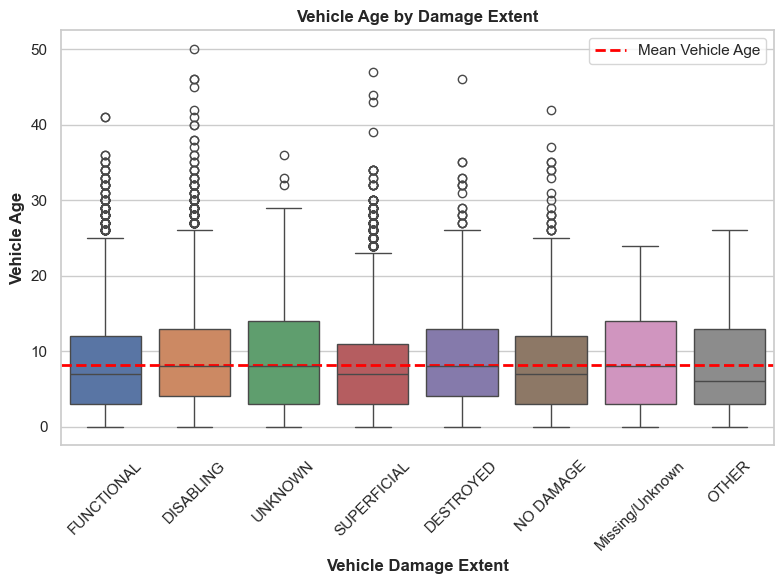

In [234]:
#Visualize vehicle age by damage extent
# Wuth mean
plt.figure(figsize=(8, 6))
sns.boxplot(x="Vehicle Damage Extent",y="Vehicle Age",data=df,hue="Vehicle Damage Extent")

# Compute overall mean vehicle age
mean_age = df["Vehicle Age"].mean()

# Add red horizontal line for the mean
plt.axhline(y=mean_age,color="red",linestyle="--",linewidth=2,label="Mean Vehicle Age")

plt.title("Vehicle Age by Damage Extent")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [156]:
from scipy.stats import kruskal                                                                                                      
import numpy as np                                                                                                                   
                                                                                                                                     
sub = df.dropna(subset=["Vehicle Age"]).copy()                                                                                       
sub = sub[~sub["Vehicle Damage Extent"].isin(["UNKNOWN", "Missing/Unknown", "OTHER"])]                                               
                                                                                                                                     
grouped = [g["Vehicle Age"].values for _, g in sub.groupby("Vehicle Damage Extent")]                                                 
H, p = kruskal(*grouped)                                                                                                             
                                                                                                                                     
n = len(sub)                                                                                                                         
k = sub["Vehicle Damage Extent"].nunique()                                                                                           
eps2 = (H - k + 1) / (n - k)                                                                                                         
                                                                                                                                     
print(f"Kruskal H={H:.3f}, p={p:.4g}, epsilon^2={eps2:.4f}")          

Kruskal H=280.383, p=1.842e-59, epsilon^2=0.0044


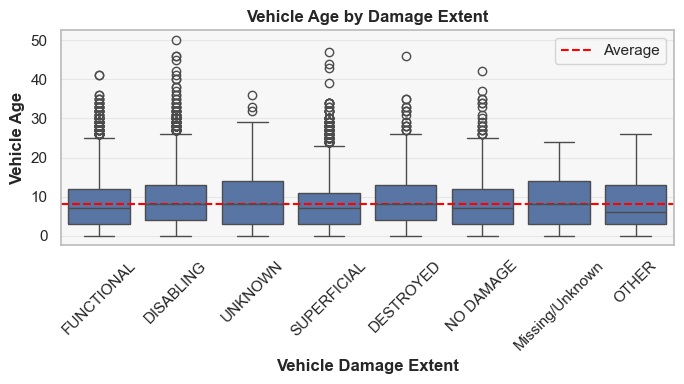

In [148]:
if "Vehicle Age" in df.columns:
    plt.figure(figsize=(7,4))
    sns.boxplot(data=df, x="Vehicle Damage Extent", y="Vehicle Age")
    plt.axhline(df["Vehicle Age"].mean(), color="red", linestyle="--", label="Average")
    plt.title("Vehicle Age by Damage Extent")
    plt.xlabel("Vehicle Damage Extent")
    plt.ylabel("Vehicle Age")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


#### 3.5.2 Vehicle Size


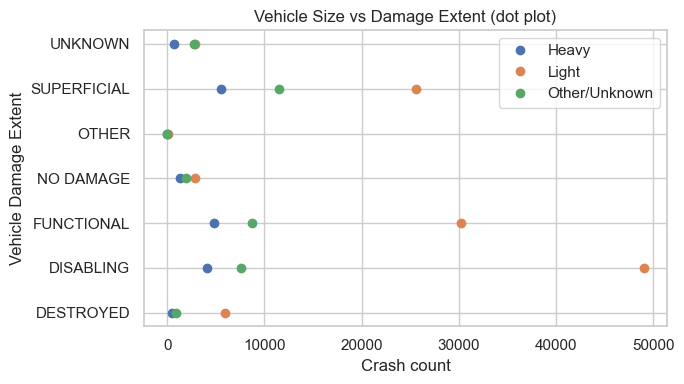

In [17]:
# Categorize vehicle body types into size groups
def size_group(v):
    s = str(v).lower()
    if any(k in s for k in ["motorcycle", "moped"]):
        return "Light"
    if any(k in s for k in ["passenger", "sedan", "coupe", "hatch", "convertible"]):
        return "Light"
    if any(k in s for k in ["van", "suv", "pickup", "truck"]):
        return "Heavy"
    return "Other/Unknown"

df["Vehicle Size"] = df["Vehicle Body Type"].apply(size_group)
size_damage = df.groupby(["Vehicle Size", "Vehicle Damage Extent"]).size().reset_index(name="count")

# Cleveland dot plot
plt.figure(figsize=(7,4))
for size in size_damage["Vehicle Size"].unique():
    sub = size_damage[size_damage["Vehicle Size"] == size]
    plt.plot(sub["count"], sub["Vehicle Damage Extent"], "o", label=size)
plt.title("Vehicle Size vs Damage Extent (dot plot)")
plt.xlabel("Crash count")
plt.ylabel("Vehicle Damage Extent")
plt.legend()
plt.tight_layout()
plt.show()


## 4. Predictive Modeling and Validation
### 4.1 Setup for Modeling


This section adds **inferential and predictive modeling** on top of the EDA.

Main goals:
1. Estimate which factors are associated with severe injury risk.
2. Quantify uncertainty with confidence intervals and p-values.
3. Validate predictive performance on unseen data.
4. Model crash **counts over time** with a Poisson framework and check overdispersion.


In [272]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import chi2

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss, log_loss,
    precision_recall_fscore_support, mean_squared_error, mean_absolute_error
)


def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)


def collapse_rare(s, min_frac=0.01):
    s = s.fillna("Missing/Unknown").astype(str)
    keep = s.value_counts(normalize=True)
    keep = keep[keep >= min_frac].index
    return np.where(s.isin(keep), s, "Other")


def binary_metrics(y_true, p, threshold=0.5):
    y_hat = (p >= threshold).astype(int)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_hat, average="binary", zero_division=0)
    return {
        "roc_auc": float(roc_auc_score(y_true, p)),
        "pr_auc": float(average_precision_score(y_true, p)),
        "brier": float(brier_score_loss(y_true, p)),
        "log_loss": float(log_loss(y_true, p, labels=[0, 1])),
        f"precision@{threshold}": float(pr),
        f"recall@{threshold}": float(rc),
        f"f1@{threshold}": float(f1),
        f"alert_rate@{threshold}": float(np.mean(y_hat)),
    }


def threshold_grid_metrics(y_true, p, thresholds):
    rows = []
    for t in thresholds:
        y_hat = (p >= t).astype(int)
        pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_hat, average='binary', zero_division=0)
        beta2 = (1 + 2**2) * pr * rc / (2**2 * pr + rc) if (2**2 * pr + rc) > 0 else 0.0
        rows.append({'threshold': float(t), 'precision': float(pr), 'recall': float(rc), 'f1': float(f1), 'f2': float(beta2), 'alert_rate': float(np.mean(y_hat))})
    return pd.DataFrame(rows)


def choose_threshold_with_precision_floor(thr_df, precision_floor=0.03):
    floors = [precision_floor, 0.025, 0.02, 0.015]
    for pf in floors:
        cand = thr_df[thr_df['precision'] >= pf]
        if len(cand) > 0:
            best = cand.sort_values(['recall', 'f1', 'precision'], ascending=[False, False, False]).iloc[0]
            return float(best['threshold']), f'max recall with precision >= {pf:.3f}', cand.sort_values(['recall', 'f1'], ascending=False)

    best = thr_df.sort_values(['f1', 'recall', 'precision'], ascending=[False, False, False]).iloc[0]
    return float(best['threshold']), 'fallback max F1 (no precision floor feasible)', thr_df.sort_values('f1', ascending=False)


def hosmer_lemeshow(y_true, p, g=10):
    d = pd.DataFrame({"y": y_true, "p": p})
    d["bin"] = pd.qcut(d["p"], q=g, duplicates="drop")
    grp = d.groupby("bin", observed=False)
    obs = grp["y"].sum().values.astype(float)
    exp = grp["p"].sum().values.astype(float)
    n = grp.size().values.astype(float)
    den = np.clip(exp * (1 - exp / np.clip(n, 1, None)), 1e-9, None)
    hl = ((obs - exp) ** 2 / den).sum()
    dof = max(len(obs) - 2, 1)
    pval = 1 - chi2.cdf(hl, dof)
    return float(hl), float(pval), int(dof)


### What Each Tool Means and Why It Is Used

- **Train/test split**: keeps a final holdout set to test generalization and reduce overfitting risk.
- **Logistic regression (Binomial GLM)**: models probability of severe injury (`0/1`).
  - Output includes **odds ratios (OR)**, **95% CI**, and **p-values**.
- **Random Forest baseline**: non-linear benchmark model; helps check whether logistic is missing strong non-linear structure.
- **Poisson GLM**: models crash **counts per time unit** (hourly counts in this notebook).
- **Overdispersion diagnostics**: checks if Poisson variance assumptions are violated.
  - If dispersion is high, Negative Binomial is fit as a robustness check.
- **Calibration and fit checks**: test whether predicted probabilities are realistic, not only discriminative.


### 4.2 Feature Engineering (Tailored to This Notebook)


In [273]:
df_base = df.copy()

df_base["CrashDT"] = pd.to_datetime(df_base["Crash Date/Time"], errors="coerce")
df_base = df_base.dropna(subset=["CrashDT"]).copy()
df_base["CrashYear"] = df_base["CrashDT"].dt.year
df_base["Weekday"] = df_base["CrashDT"].dt.day_name()
df_base["HourBin"] = pd.cut(
    df_base["CrashDT"].dt.hour,
    bins=[-1, 5, 9, 15, 19, 23],
    labels=["Night(0-5)", "AM Peak(6-9)", "Midday(10-15)", "PM Peak(16-19)", "Evening(20-23)"]
).astype(str)

# Vehicle year/age cleaning
vy = pd.to_numeric(df_base["Vehicle Year"], errors="coerce")
bad_year = vy.isna() | (vy < 1900) | (vy > (df_base["CrashYear"] + 1))
df_base["VehicleYearClean"] = vy.mask(bad_year)
df_base["VehicleAge"] = df_base["CrashYear"] - df_base["VehicleYearClean"]
df_base.loc[(df_base["VehicleAge"] < 0) | (df_base["VehicleAge"] > 50), "VehicleAge"] = np.nan
df_base["VehicleAgeMissing"] = df_base["VehicleAge"].isna().astype(int)

# Speed cleaning
sp = pd.to_numeric(df_base["Speed Limit"], errors="coerce")
df_base["SpeedLimitClean"] = sp.mask((sp < 5) | (sp > 90))
df_base["SpeedMissing"] = df_base["SpeedLimitClean"].isna().astype(int)

# Flags
sub = df_base["Driver Substance Abuse"].fillna("").astype(str).str.upper()
dst = df_base["Driver Distracted By"].fillna("").astype(str).str.upper()
df_base["SubstanceFlag"] = sub.str.contains("ALCOHOL|DRUG|MEDICATION", regex=True).astype(int)
df_base["DistractedFlag"] = (~dst.str.contains("NOT DISTRACTED", regex=False)).astype(int)

# Grouped categorical features
w = df_base["Weather"].fillna("").astype(str).str.upper()
s = df_base["Surface Condition"].fillna("").astype(str).str.upper()
l = df_base["Light"].fillna("").astype(str).str.upper()
t = df_base["Traffic Control"].fillna("").astype(str).str.upper()

df_base["WeatherGroup"] = np.select(
    [w.str.contains("RAIN|SNOW|FOG|SLEET|ICE|WINTRY", regex=True), w.str.contains("CLEAR", regex=False)],
    ["Adverse", "Clear"],
    default="Other"
)
df_base["SurfaceGroup"] = np.select(
    [s.str.contains("DRY", regex=False), s.str.contains("WET", regex=False), s.str.contains("SNOW|ICE|SLUSH", regex=True)],
    ["Dry", "Wet", "Snow/Ice"],
    default="Other"
)
df_base["LightGroup"] = np.select(
    [l.str.contains("DAYLIGHT", regex=False), l.str.contains("DARK", regex=False), l.str.contains("DAWN|DUSK", regex=True)],
    ["Daylight", "Dark", "Dawn/Dusk"],
    default="Other"
)
df_base["TrafficGroup"] = np.select(
    [t.str.contains("NO CONTROLS", regex=False), t.str.contains("TRAFFIC SIGNAL", regex=False), t.str.contains("STOP SIGN|YIELD SIGN", regex=True)],
    ["NoControls", "Signal", "Stop/Yield"],
    default="Other"
)

# Severe injury target
sev = df_base["Injury Severity"].fillna("").astype(str).str.upper().str.strip()
severe = {"SUSPECTED SERIOUS INJURY", "FATAL INJURY"}
non_severe = {"NO APPARENT INJURY", "POSSIBLE INJURY", "SUSPECTED MINOR INJURY"}
keep = sev.isin(severe | non_severe)

df_sev = df_base.loc[keep].copy()
df_sev["SevereInjury"] = sev[keep].isin(severe).astype(int)

cat_cols = ["WeatherGroup", "SurfaceGroup", "LightGroup", "TrafficGroup", "Route Type", "Weekday", "HourBin"]
num_cols = ["VehicleAge", "SpeedLimitClean", "CrashYear", "VehicleAgeMissing", "SpeedMissing", "SubstanceFlag", "DistractedFlag"]

for c in cat_cols:
    df_sev[c] = collapse_rare(df_sev[c], min_frac=0.01)

X = df_sev[cat_cols + num_cols].copy()
y = df_sev["SevereInjury"].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Rows:", len(df_sev))
print("Severe prevalence %:", round(df_sev["SevereInjury"].mean() * 100, 3))


Rows: 65842
Severe prevalence %: 0.91


  1. Rows: 65842
     After all filtering/cleaning for the severe-injury model, you trained/tested on 65,842 records.
  2. Severe prevalence %: 0.91
     Only 0.91% of those rows are severe injuries (about 599 severe cases, rest non-severe).

  Why this is important:

  - Your target is highly imbalanced.
  - Accuracy alone would be misleading.
  - You should focus on PR-AUC, recall/precision, calibration, and class-weighted models (which you already added).

### Why This Feature Engineering Matters

- `Vehicle Year` can contain impossible values (`0`, `9999`, future years). Those are converted to missing before deriving `VehicleAge`.
- Missingness indicators (`VehicleAgeMissing`, `SpeedMissing`) preserve useful signal instead of silently dropping rows.
- Rare categorical levels are collapsed to `Other` to stabilize estimation and avoid noisy coefficients.
- Severe injury is explicitly defined as:
  - `SUSPECTED SERIOUS INJURY` or `FATAL INJURY`.


C:\Users\liorbj\AppData\Local\Temp\ipykernel_37148\1307006355.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, ax=axes[0], palette=['#4C72B0', '#DD8452'])


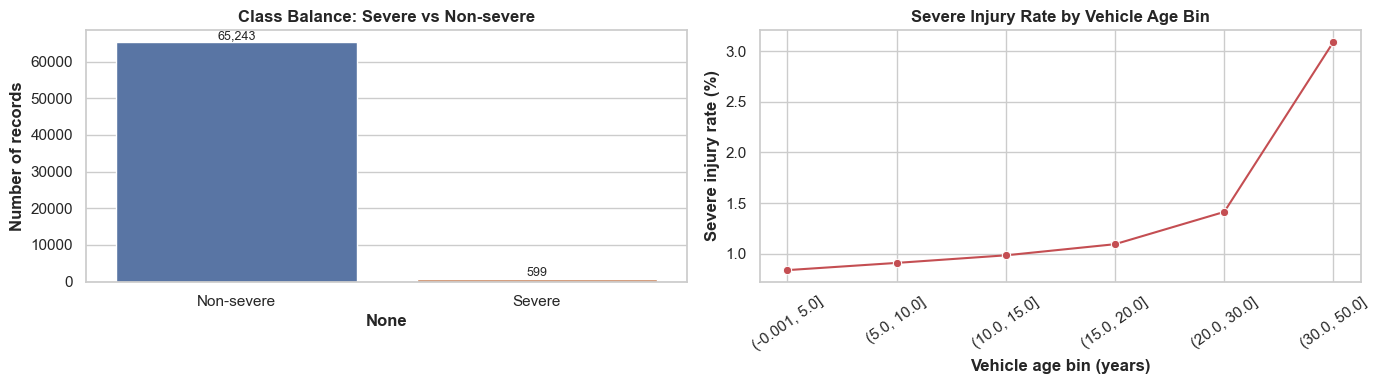

In [274]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Class balance
class_counts = (
    pd.Series(y)
    .map({0: 'Non-severe', 1: 'Severe'})
    .value_counts()
    .reindex(['Non-severe', 'Severe'])
)
sns.barplot(x=class_counts.index, y=class_counts.values, ax=axes[0], palette=['#4C72B0', '#DD8452'])
axes[0].set_title('Class Balance: Severe vs Non-severe')
axes[0].set_ylabel('Number of records')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=9)

# Severe rate by vehicle age bin
tmp = df_sev[['VehicleAge', 'SevereInjury']].dropna().copy()
tmp['AgeBin'] = pd.cut(tmp['VehicleAge'], bins=[0, 5, 10, 15, 20, 30, 50], include_lowest=True)
rate = tmp.groupby('AgeBin', observed=False)['SevereInjury'].mean().mul(100)
rate.index = rate.index.astype(str)
rate = rate.reset_index(name='SevereRatePct')

sns.lineplot(data=rate, x='AgeBin', y='SevereRatePct', marker='o', ax=axes[1], color='#C44E52')
axes[1].set_title('Severe Injury Rate by Vehicle Age Bin')
axes[1].set_xlabel('Vehicle age bin (years)')
axes[1].set_ylabel('Severe injury rate (%)')
axes[1].tick_params(axis='x', rotation=35)

plt.tight_layout()
plt.show()


### 4.3 Logistic Regression for Severe Injury Risk (OR + CI + p-values)


In [275]:
tr = X_train.copy()
te = X_test.copy()

med = tr[num_cols].median()
for c in num_cols:
    tr[c] = pd.to_numeric(tr[c], errors="coerce").fillna(med[c])
    te[c] = pd.to_numeric(te[c], errors="coerce").fillna(med[c])

for c in cat_cols:
    tr[c] = tr[c].fillna("Missing/Unknown").astype(str)
    te[c] = te[c].fillna("Missing/Unknown").astype(str)

Xtr = pd.get_dummies(tr, columns=cat_cols, drop_first=True, dtype=float)
Xte = pd.get_dummies(te, columns=cat_cols, drop_first=True, dtype=float)
Xte = Xte.reindex(columns=Xtr.columns, fill_value=0.0)

Xtr = sm.add_constant(Xtr, has_constant="add")
Xte = sm.add_constant(Xte, has_constant="add")

logit_inf = sm.GLM(y_train, Xtr, family=sm.families.Binomial()).fit()

ci = logit_inf.conf_int()
or_table = pd.DataFrame({
    "term": logit_inf.params.index,
    "coef": logit_inf.params.values,
    "OR": np.exp(logit_inf.params.values),
    "CI_low_95": np.exp(ci[0].values),
    "CI_high_95": np.exp(ci[1].values),
    "p_value": logit_inf.pvalues.values
}).sort_values("p_value")
or_table = or_table[or_table["term"] != "const"]

display(or_table.head(30))

p_test = logit_inf.predict(Xte).values
logit_metrics = binary_metrics(y_test, p_test)

hl_stat, hl_p, hl_df = hosmer_lemeshow(y_test, p_test, g=10)
eps = 1e-6
lp = np.log(np.clip(p_test, eps, 1-eps) / np.clip(1-p_test, eps, 1-eps))
cal = sm.GLM(y_test, sm.add_constant(lp), family=sm.families.Binomial()).fit()

print("Logistic test metrics:", logit_metrics)
print(f"Hosmer-Lemeshow: stat={hl_stat:.3f}, df={hl_df}, p={hl_p:.4g}")
print(f"Calibration intercept={cal.params[0]:.4f}, slope={cal.params[1]:.4f}")


,term,coef,OR,CI_low_95,CI_high_95,p_value
2,SpeedLimitClean,0.054365,1.055870,1.041574,1.070363,5.449005e-15
6,SubstanceFlag,1.095064,2.989373,2.177475,4.103999,1.263168e-11
7,DistractedFlag,0.337485,1.401418,1.163658,1.687758,3.739426e-04
24,Route Type_US (State),-1.089073,0.336528,0.179424,0.631194,6.889871e-04
1,VehicleAge,0.023325,1.023599,1.008811,1.038605,1.681812e-03
19,Route Type_Interstate (State),-1.204269,0.299911,0.138974,0.647220,2.151066e-03
17,TrafficGroup_Signal,-0.305939,0.736431,0.593515,0.913761,5.448648e-03
33,HourBin_Night(0-5),0.643445,1.903025,1.190785,3.041275,7.146567e-03
4,VehicleAgeMissing,-1.754315,0.173026,0.042930,0.697371,1.363327e-02
23,Route Type_Other,-2.104261,0.121936,0.016985,0.875363,3.640938e-02


Logistic test metrics: {'roc_auc': 0.6379208496181061, 'pr_auc': 0.025109696027228755, 'brier': 0.00898083519961396, 'log_loss': 0.05049575496125057, 'precision@0.5': 0.0, 'recall@0.5': 0.0, 'f1@0.5': 0.0, 'alert_rate@0.5': 0.0}
Hosmer-Lemeshow: stat=14.018, df=8, p=0.08129
Calibration intercept=-0.9814, slope=0.7794


### 4.3.1 Threshold Tuning (Precision-Constrained)

Because severe injury is rare (~0.9%), a fixed threshold of `0.5` is usually not optimal.

Instead of maximizing recall alone, we choose threshold with this rule:
1. Prefer thresholds meeting a minimum precision floor (default target: 3%).
2. Within feasible thresholds, maximize recall.
3. If no threshold meets the floor, fall back gradually (2.5%, 2%, 1.5%) and finally to max-F1.


Threshold rule: max recall with precision >= 0.030
Selected threshold: 0.6978
Top validation thresholds (by rule ranking):


,threshold,precision,recall,f1,f2,alert_rate
217,0.697831,0.032689,0.183333,0.055485,0.095403,0.051105
216,0.694639,0.031609,0.183333,0.053922,0.093537,0.052851
215,0.691446,0.030261,0.183333,0.051948,0.091135,0.055205
219,0.704217,0.032520,0.166667,0.054422,0.091324,0.046701
218,0.701024,0.030960,0.166667,0.052219,0.088810,0.049055
225,0.723373,0.039337,0.158333,0.063018,0.098650,0.036677
224,0.720181,0.037549,0.158333,0.060703,0.096349,0.038424
223,0.716988,0.035581,0.158333,0.058104,0.093688,0.040550
222,0.713795,0.034735,0.158333,0.056972,0.092502,0.041537
221,0.710602,0.033929,0.158333,0.055882,0.091346,0.042524


Test @0.5: {'precision': 0.013570994531091757, 'recall': 0.5583333333333333, 'f1': 0.026497923670160173, 'alert_rate': 0.37489558812362367}
Test @tuned: {'precision': 0.02459016393442623, 'recall': 0.15, 'f1': 0.04225352112676056, 'alert_rate': 0.05558508618725795}


,Threshold,Precision,Recall,F1,AlertRate
0,0.500000,0.013571,0.558333,0.026498,0.374896
1,0.697831,0.024590,0.150000,0.042254,0.055585


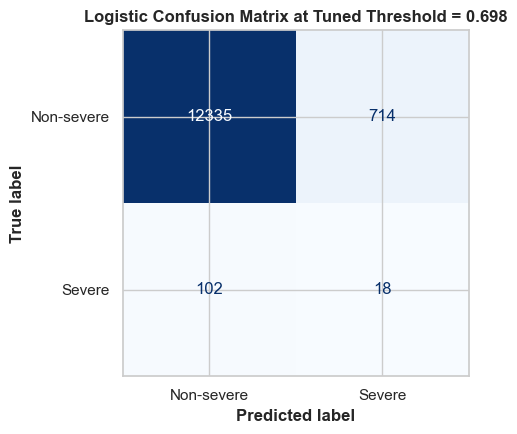

In [276]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Build prediction-focused logistic pipeline
pre_t = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", make_ohe())]), cat_cols),
])

log_tuned = Pipeline([
    ("pre", pre_t),
    ("clf", LogisticRegression(max_iter=3000, solver="liblinear", class_weight="balanced", random_state=42)),
])

# Inner split for threshold selection (no test leakage)
X_tr_in, X_val_in, y_tr_in, y_val_in = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

log_tuned.fit(X_tr_in, y_tr_in)
p_val = log_tuned.predict_proba(X_val_in)[:, 1]

thresholds = np.linspace(0.005, 0.80, 250)
thr_df = threshold_grid_metrics(y_val_in, p_val, thresholds)

best_t, threshold_rule, ranked = choose_threshold_with_precision_floor(thr_df, precision_floor=0.03)

# Refit on full training and evaluate on test
log_tuned.fit(X_train, y_train)
p_test_tuned = log_tuned.predict_proba(X_test)[:, 1]

yhat_05 = (p_test_tuned >= 0.5).astype(int)
yhat_t = (p_test_tuned >= best_t).astype(int)

pr05, rc05, f105, _ = precision_recall_fscore_support(y_test, yhat_05, average='binary', zero_division=0)
prt, rct, f1t, _ = precision_recall_fscore_support(y_test, yhat_t, average='binary', zero_division=0)

print('Threshold rule:', threshold_rule)
print('Selected threshold:', round(best_t, 4))
print('Top validation thresholds (by rule ranking):')
display(ranked.head(10))

print('Test @0.5:', {'precision': float(pr05), 'recall': float(rc05), 'f1': float(f105), 'alert_rate': float(np.mean(yhat_05))})
print('Test @tuned:', {'precision': float(prt), 'recall': float(rct), 'f1': float(f1t), 'alert_rate': float(np.mean(yhat_t))})

threshold_compare = pd.DataFrame([
    {'Threshold': 0.5, 'Precision': pr05, 'Recall': rc05, 'F1': f105, 'AlertRate': np.mean(yhat_05)},
    {'Threshold': best_t, 'Precision': prt, 'Recall': rct, 'F1': f1t, 'AlertRate': np.mean(yhat_t)},
])
display(threshold_compare)

# Keep for later comparison section
best_t_logistic = best_t

cm = confusion_matrix(y_test, yhat_t)
fig, ax = plt.subplots(figsize=(5.5, 4.5))
ConfusionMatrixDisplay(cm, display_labels=['Non-severe', 'Severe']).plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title(f'Logistic Confusion Matrix at Tuned Threshold = {best_t:.3f}')
plt.tight_layout()
plt.show()


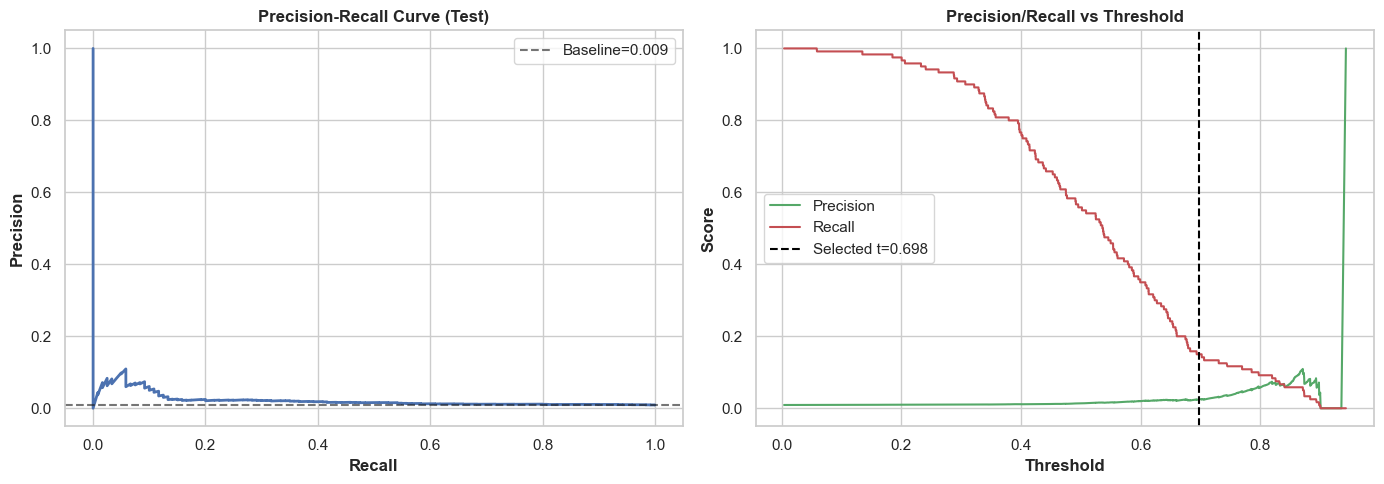

In [277]:
from sklearn.metrics import precision_recall_curve

sns.set_theme(style='whitegrid')

# Precision-recall curve + threshold behavior
prec, rec, thr = precision_recall_curve(y_test, p_test_tuned)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(rec, prec, color='#4C72B0', linewidth=2)
axes[0].set_title('Precision-Recall Curve (Test)')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].axhline(np.mean(y_test), color='k', linestyle='--', alpha=0.6, label=f'Baseline={np.mean(y_test):.3f}')
axes[0].legend()

# Threshold trace
thr_plot = pd.DataFrame({'threshold': thr, 'precision': prec[1:], 'recall': rec[1:]})
axes[1].plot(thr_plot['threshold'], thr_plot['precision'], label='Precision', color='#55A868')
axes[1].plot(thr_plot['threshold'], thr_plot['recall'], label='Recall', color='#C44E52')
axes[1].axvline(best_t, color='black', linestyle='--', label=f'Selected t={best_t:.3f}')
axes[1].set_title('Precision/Recall vs Threshold')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Score')
axes[1].legend()

plt.tight_layout()
plt.show()


### How to Read Logistic Regression Output

For each predictor term:
- **OR > 1**: higher odds of severe injury.
- **OR < 1**: lower odds of severe injury.
- **95% CI**: uncertainty range for OR. If CI crosses 1, effect may be weak/uncertain.
- **p-value**: evidence against null effect.

Important: with large datasets, very small effects can still have tiny p-values.
Always combine significance with effect size (distance of OR from 1).


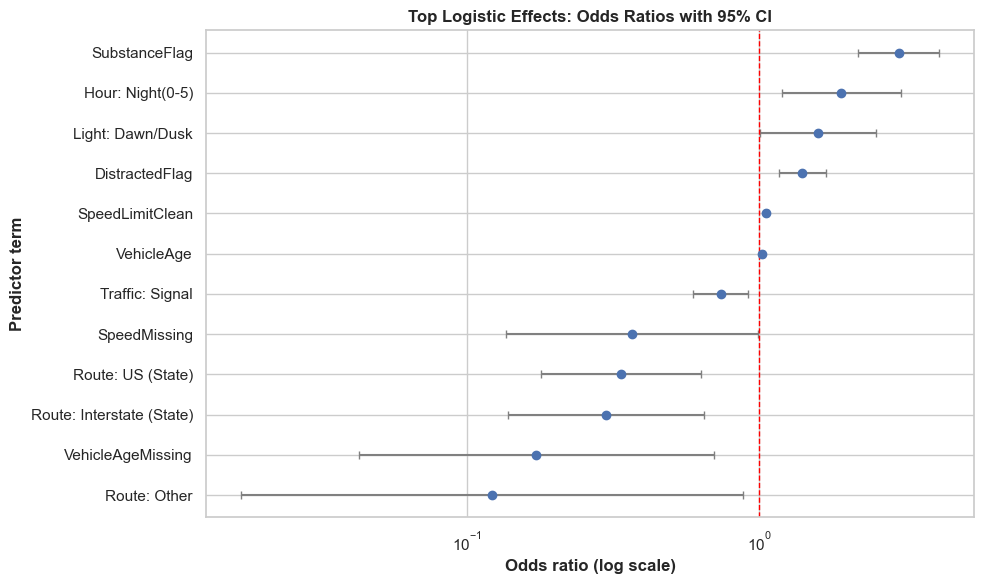

In [278]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

plot_df = or_table.copy()
plot_df = plot_df.replace([np.inf, -np.inf], np.nan)
plot_df = plot_df.dropna(subset=['OR', 'CI_low_95', 'CI_high_95', 'p_value'])
plot_df = plot_df[(plot_df['CI_low_95'] > 0) & (plot_df['OR'] > 0)]

# Keep interpretable terms; avoid ultra-wide CIs from sparse levels
plot_df = plot_df[plot_df['CI_high_95'] < 100]
if len(plot_df) == 0:
    print('No finite OR terms to plot after filtering.')
else:
    plot_df['abs_log_or'] = np.abs(np.log(plot_df['OR']))
    # Prefer statistically strong and practically noticeable effects
    top = plot_df.sort_values(['p_value', 'abs_log_or'], ascending=[True, False]).head(12).copy()
    top = top.sort_values('OR')

    def short_name(s):
        s = str(s)
        s = s.replace('WeatherGroup_', 'Weather: ')
        s = s.replace('SurfaceGroup_', 'Surface: ')
        s = s.replace('LightGroup_', 'Light: ')
        s = s.replace('TrafficGroup_', 'Traffic: ')
        s = s.replace('Route Type_', 'Route: ')
        s = s.replace('Weekday_', 'Weekday: ')
        s = s.replace('HourBin_', 'Hour: ')
        return s[:70]

    top['term_short'] = top['term'].map(short_name)

    fig, ax = plt.subplots(figsize=(10, 6))
    xerr = np.vstack([top['OR'] - top['CI_low_95'], top['CI_high_95'] - top['OR']])
    ax.errorbar(top['OR'], top['term_short'], xerr=xerr, fmt='o', color='#4C72B0', ecolor='gray', capsize=3)
    ax.axvline(1.0, color='red', linestyle='--', linewidth=1)
    ax.set_xscale('log')
    ax.set_title('Top Logistic Effects: Odds Ratios with 95% CI')
    ax.set_xlabel('Odds ratio (log scale)')
    ax.set_ylabel('Predictor term')
    plt.tight_layout()
    plt.show()


### 4.4 Model Comparison: Logistic vs Random Forest Baseline (Fair Threshold Protocol)


In [279]:
pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", make_ohe())]), cat_cols),
])

log_clf = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=2500, solver="liblinear", class_weight="balanced", random_state=42)),
])

rf_clf = Pipeline([
    ("pre", pre),
    ("clf", RandomForestClassifier(
        n_estimators=350, min_samples_leaf=8,
        class_weight="balanced_subsample", random_state=42, n_jobs=-1
    )),
])

# Use same validation protocol for both models
X_fit, X_val, y_fit, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

# Logistic threshold
log_clf.fit(X_fit, y_fit)
p_val_log = log_clf.predict_proba(X_val)[:, 1]
thr_df_log = threshold_grid_metrics(y_val, p_val_log, np.linspace(0.005, 0.80, 250))
log_t, log_rule, _ = choose_threshold_with_precision_floor(thr_df_log, precision_floor=0.03)

# RF threshold
rf_clf.fit(X_fit, y_fit)
p_val_rf = rf_clf.predict_proba(X_val)[:, 1]
thr_df_rf = threshold_grid_metrics(y_val, p_val_rf, np.linspace(0.005, 0.80, 250))
rf_t, rf_rule, _ = choose_threshold_with_precision_floor(thr_df_rf, precision_floor=0.03)

# Refit both on full train, evaluate on test
log_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

p_log = log_clf.predict_proba(X_test)[:, 1]
p_rf = rf_clf.predict_proba(X_test)[:, 1]

# Probability-quality metrics (threshold-free)
cmp_prob = pd.DataFrame([
    {"model": "Logistic (balanced)", **binary_metrics(y_test, p_log, threshold=0.5)},
    {"model": "Random Forest baseline", **binary_metrics(y_test, p_rf, threshold=0.5)},
]).set_index("model")

display(cmp_prob[[
    'roc_auc', 'pr_auc', 'brier', 'log_loss',
    'precision@0.5', 'recall@0.5', 'f1@0.5', 'alert_rate@0.5'
]])

# Fair threshold-based operating points

def op_metrics(y_true, p, t):
    y_hat = (p >= t).astype(int)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_hat, average='binary', zero_division=0)
    return {'threshold': float(t), 'precision': float(pr), 'recall': float(rc), 'f1': float(f1), 'alert_rate': float(np.mean(y_hat))}

cmp_operating = pd.DataFrame([
    {'model': 'Logistic (balanced)', **op_metrics(y_test, p_log, log_t), 'threshold_rule': log_rule},
    {'model': 'Random Forest baseline', **op_metrics(y_test, p_rf, rf_t), 'threshold_rule': rf_rule},
]).set_index('model')

display(cmp_operating)

# Keep chosen thresholds for interpretation
best_t_logistic = log_t
best_t_rf = rf_t
print('Chosen threshold (logistic):', round(log_t, 4), '| rule:', log_rule)
print('Chosen threshold (RF):', round(rf_t, 4), '| rule:', rf_rule)


,roc_auc,pr_auc,brier,log_loss,precision@0.5,recall@0.5,f1@0.5,alert_rate@0.5
model,,,,,,,,
Logistic (balanced),0.638376,0.022435,0.221198,0.629473,0.013571,0.558333,0.026498,0.374896
Random Forest baseline,0.625799,0.017577,0.027067,0.146772,0.000000,0.000000,0.000000,0.002886


,threshold,precision,recall,f1,alert_rate,threshold_rule
model,,,,,,
Logistic (balanced),0.697831,0.024590,0.150000,0.042254,0.055585,max recall with precision >= 0.030
Random Forest baseline,0.391325,0.040936,0.058333,0.048110,0.012985,max recall with precision >= 0.030


Chosen threshold (logistic): 0.6978 | rule: max recall with precision >= 0.030
Chosen threshold (RF): 0.3913 | rule: max recall with precision >= 0.030


### How to Read the Model Comparison Metrics

- **ROC-AUC**: discrimination across all thresholds (higher is better).
- **PR-AUC**: precision-recall quality; important for imbalanced severe-injury target.
- **Brier score**: probability calibration error (lower is better).
- **Log-loss**: penalizes wrong/confident probability predictions (lower is better).
- **Precision/Recall/F1 @ 0.5**: threshold-based operating point.

Use this comparison to justify whether logistic is sufficient or a non-linear baseline adds value.


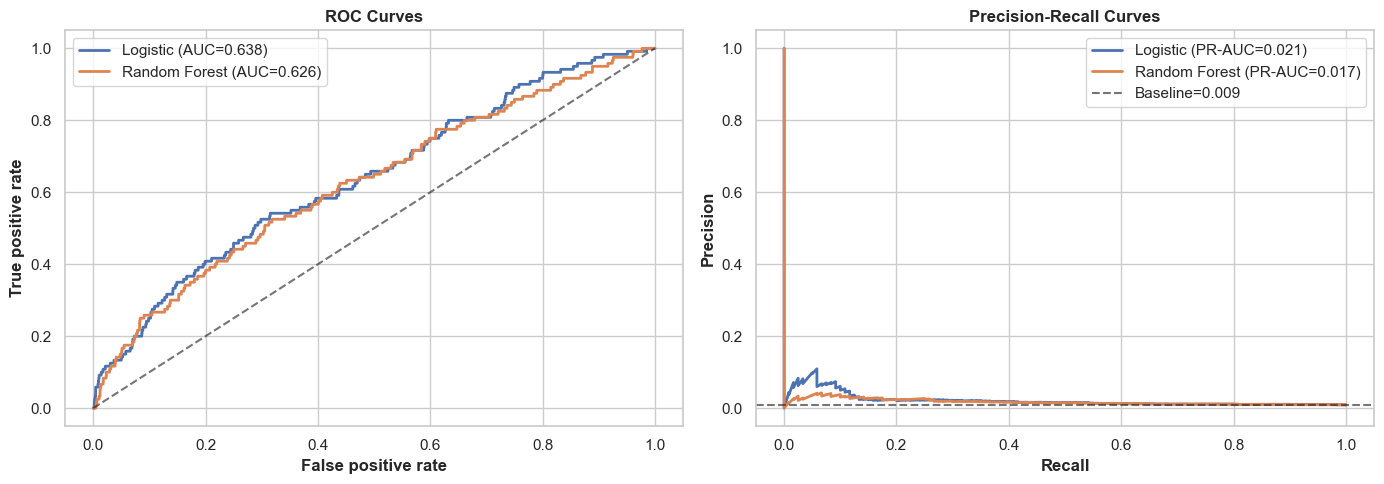

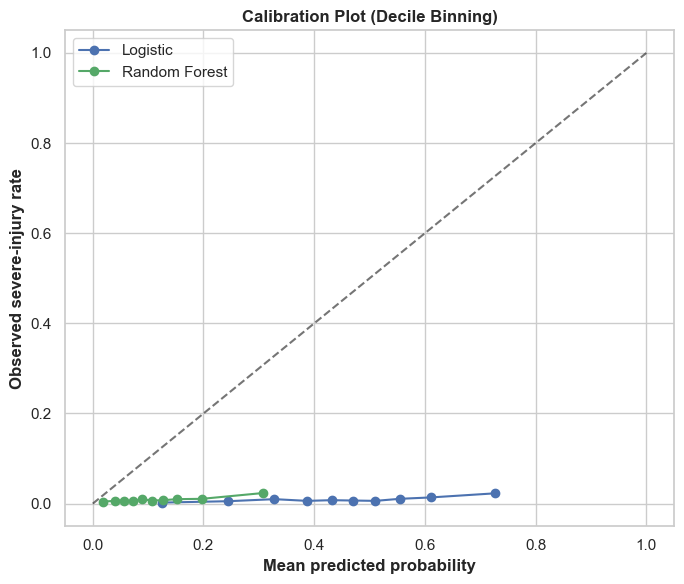

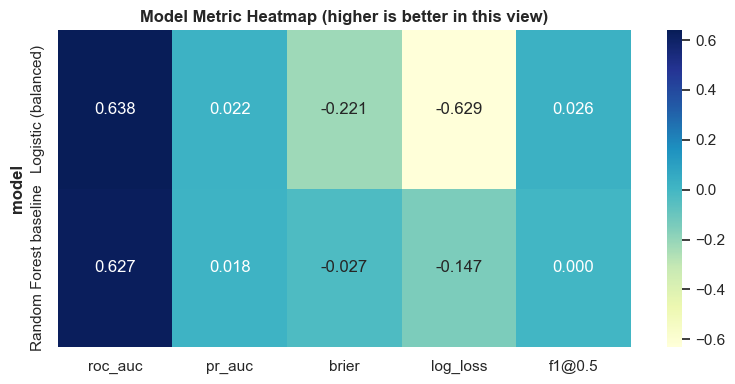

In [280]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc

sns.set_theme(style='whitegrid')

# ROC + PR curves
fpr_log, tpr_log, _ = roc_curve(y_test, p_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, p_rf)

prec_log, rec_log, _ = precision_recall_curve(y_test, p_log)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, p_rf)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(fpr_log, tpr_log, label=f'Logistic (AUC={auc(fpr_log, tpr_log):.3f})', linewidth=2)
axes[0].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc(fpr_rf, tpr_rf):.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.6)
axes[0].set_title('ROC Curves')
axes[0].set_xlabel('False positive rate')
axes[0].set_ylabel('True positive rate')
axes[0].legend()

axes[1].plot(rec_log, prec_log, label=f'Logistic (PR-AUC={auc(rec_log, prec_log):.3f})', linewidth=2)
axes[1].plot(rec_rf, prec_rf, label=f'Random Forest (PR-AUC={auc(rec_rf, prec_rf):.3f})', linewidth=2)
base_rate = np.mean(y_test)
axes[1].axhline(base_rate, color='k', linestyle='--', alpha=0.6, label=f'Baseline={base_rate:.3f}')
axes[1].set_title('Precision-Recall Curves')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend()

plt.tight_layout()
plt.show()

# Calibration plot by deciles
cal_df = pd.DataFrame({'y': y_test, 'p_log': p_log, 'p_rf': p_rf})
fig, ax = plt.subplots(figsize=(7, 6))

for col, label, color in [('p_log', 'Logistic', '#4C72B0'), ('p_rf', 'Random Forest', '#55A868')]:
    tmp = cal_df[['y', col]].copy()
    tmp['bin'] = pd.qcut(tmp[col], q=10, duplicates='drop')
    grp = tmp.groupby('bin', observed=False)
    pred = grp[col].mean().values
    obs = grp['y'].mean().values
    ax.plot(pred, obs, marker='o', label=label, color=color)

ax.plot([0, 1], [0, 1], 'k--', alpha=0.6)
ax.set_title('Calibration Plot (Decile Binning)')
ax.set_xlabel('Mean predicted probability')
ax.set_ylabel('Observed severe-injury rate')
ax.legend()
plt.tight_layout()
plt.show()

# Metric table heatmap
plt.figure(figsize=(8, 4))
heat = cmp[['roc_auc', 'pr_auc', 'brier', 'log_loss', 'f1@0.5']].copy()
heat['brier'] = -heat['brier']
heat['log_loss'] = -heat['log_loss']
sns.heatmap(heat, annot=True, fmt='.3f', cmap='YlGnBu')
plt.title('Model Metric Heatmap (higher is better in this view)')
plt.tight_layout()
plt.show()


### 4.5 Count Modeling for Crash Frequency (3-Hour Bins + Robust NB Check)


In [281]:
# Less sparse aggregation than hourly to stabilize count models
counts = df_base.set_index("CrashDT").resample("3h").size().rename("CrashCount").to_frame()
counts["HourBin3H"] = counts.index.hour.astype(str)
counts["Weekday"] = counts.index.day_name()
counts["Month"] = counts.index.month_name().str[:3]
counts["Trend"] = np.arange(len(counts), dtype=float)

split = int(len(counts) * 0.8)
train_h = counts.iloc[:split].copy()
test_h = counts.iloc[split:].copy()

formula = "CrashCount ~ C(HourBin3H) + C(Weekday) + C(Month) + Trend"
pois = sm.GLM.from_formula(formula, data=train_h, family=sm.families.Poisson()).fit()
pred_pois = pois.predict(test_h)

dispersion = float(pois.pearson_chi2 / max(pois.df_resid, 1))
var_mean_ratio = float(train_h["CrashCount"].var() / max(train_h["CrashCount"].mean(), 1e-9))
obs_zero = float((train_h["CrashCount"] == 0).mean())
exp_zero = float(np.exp(-pois.fittedvalues).mean())

print({
    "Poisson_test_RMSE": float(np.sqrt(mean_squared_error(test_h["CrashCount"], pred_pois))),
    "Poisson_test_MAE": float(mean_absolute_error(test_h["CrashCount"], pred_pois)),
    "Poisson_AIC": float(pois.aic),
    "Pearson_dispersion": dispersion,
    "Variance_to_mean": var_mean_ratio,
    "Observed_zero_rate": obs_zero,
    "Expected_zero_rate_poisson": exp_zero
})

# Robust fallback: GLM Negative Binomial with MOM alpha
use_nb = False
nb = None
pred_nb = None
alpha_mom = None

if dispersion > 1.5:
    mean_y = train_h["CrashCount"].mean()
    var_y = train_h["CrashCount"].var()
    alpha_mom = float(max((var_y - mean_y) / max(mean_y**2, 1e-9), 1e-6))
    try:
        nb = sm.GLM.from_formula(
            formula,
            data=train_h,
            family=sm.families.NegativeBinomial(alpha=alpha_mom)
        ).fit()
        pred_nb = nb.predict(test_h)
        use_nb = np.isfinite(nb.aic)
    except Exception as e:
        print('NB fit failed:', e)
        use_nb = False

if use_nb:
    print('Using Negative Binomial as primary count model (overdispersion handled).')
    print({
        "NB_alpha_MOM": alpha_mom,
        "NB_test_RMSE": float(np.sqrt(mean_squared_error(test_h["CrashCount"], pred_nb))),
        "NB_test_MAE": float(mean_absolute_error(test_h["CrashCount"], pred_nb)),
        "NB_AIC": float(nb.aic)
    })
    count_model_used = 'Negative Binomial (GLM)'
    pred_count_main = pred_nb
    infer_model = nb
else:
    print('Using Poisson as primary count model.')
    count_model_used = 'Poisson'
    pred_count_main = pred_pois
    infer_model = pois

rr = pd.DataFrame({
    "term": infer_model.params.index,
    "coef": infer_model.params.values,
    "RateRatio": np.exp(infer_model.params.values),
    "p_value": infer_model.pvalues.values
}).sort_values("p_value")

display(rr.head(25))
print('Count model used for inference:', count_model_used)


{'Poisson_test_RMSE': 4.296754066337602, 'Poisson_test_MAE': 2.9585376350331183, 'Poisson_AIC': 146822.75051029545, 'Pearson_dispersion': 6.633083471056364, 'Variance_to_mean': 8.976773024925349, 'Observed_zero_rate': 0.6559720761212585, 'Expected_zero_rate_poisson': 0.18746458097024}
Using Negative Binomial as primary count model (overdispersion handled).
{'NB_alpha_MOM': 3.155702847692967, 'NB_test_RMSE': 4.301958548273546, 'NB_test_MAE': 2.966784483593571, 'NB_AIC': 71055.64557196936}


,term,coef,RateRatio,p_value
2,C(HourBin3H)[T.15],1.898694,6.677169,1.169439e-259
1,C(HourBin3H)[T.12],1.600996,4.957969,1.569890e-183
3,C(HourBin3H)[T.18],1.471901,4.357512,1.094835e-154
7,C(HourBin3H)[T.9],1.470561,4.351677,2.113141e-154
6,C(HourBin3H)[T.6],1.354736,3.875739,1.066821e-130
4,C(HourBin3H)[T.21],0.776125,2.173036,1.103096e-42
25,Trend,-0.000018,0.999982,2.295291e-16
22,C(Month)[T.Nov],0.343280,1.409563,2.837741e-07
15,C(Month)[T.Dec],0.260892,1.298088,8.851033e-05
10,C(Weekday)[T.Sunday],-0.186757,0.829645,1.969433e-04


Count model used for inference: Negative Binomial (GLM)


### How to Read the Count-Model Section

- Counts are modeled in **3-hour bins** (less sparse than hourly).
- Poisson is fit first, then overdispersion is checked.
- If overdispersion is strong, a **GLM Negative Binomial** is used as primary model.
- Rate Ratio (RR) interpretation:
  - `RR > 1`: multiplicative increase in expected count.
  - `RR < 1`: multiplicative decrease in expected count.


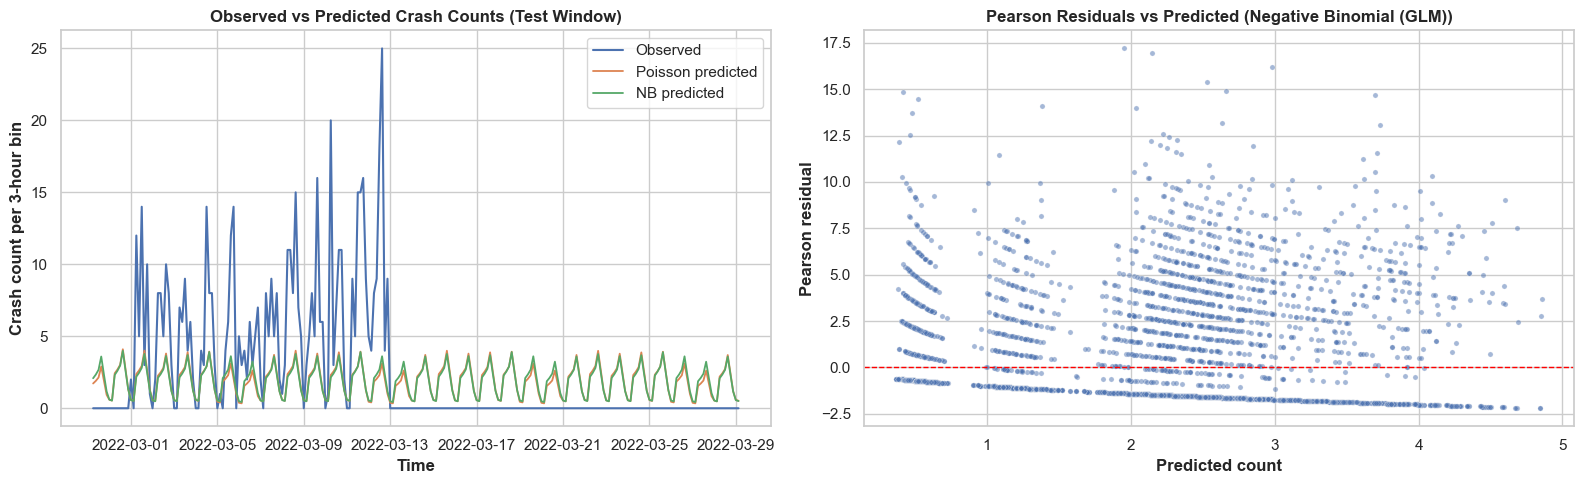

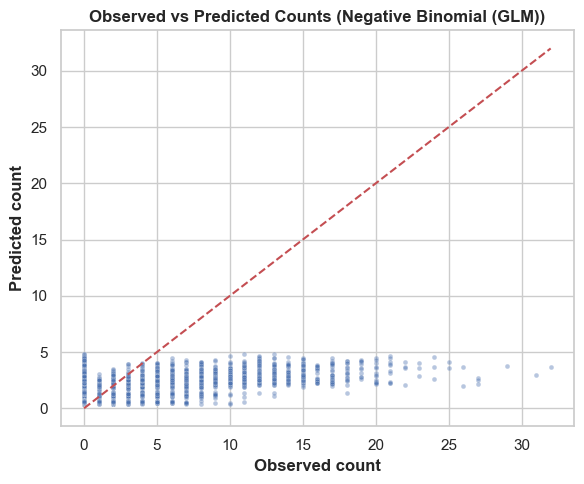

In [282]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

plot_df = test_h[['CrashCount']].copy()
plot_df['PoissonPred'] = np.asarray(pred_pois)
plot_df['MainPred'] = np.asarray(pred_count_main)
if pred_nb is not None:
    plot_df['NBPred'] = np.asarray(pred_nb)

# 1) Time-series comparison on first 30 days equivalent for 3h bins
window = min(len(plot_df), 8 * 30)
show_df = plot_df.iloc[:window].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].plot(show_df.index, show_df['CrashCount'], label='Observed', linewidth=1.5)
axes[0].plot(show_df.index, show_df['PoissonPred'], label='Poisson predicted', linewidth=1.3)
if 'NBPred' in show_df.columns:
    axes[0].plot(show_df.index, show_df['NBPred'], label='NB predicted', linewidth=1.3)
axes[0].set_title('Observed vs Predicted Crash Counts (Test Window)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Crash count per 3-hour bin')
axes[0].legend()

# 2) Residual diagnostics for chosen main model
resid = (plot_df['CrashCount'] - plot_df['MainPred']) / np.sqrt(np.clip(plot_df['MainPred'], 1e-9, None))
sns.scatterplot(x=plot_df['MainPred'], y=resid, s=14, alpha=0.5, ax=axes[1], color='#4C72B0')
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1].set_title(f'Pearson Residuals vs Predicted ({count_model_used})')
axes[1].set_xlabel('Predicted count')
axes[1].set_ylabel('Pearson residual')

plt.tight_layout()
plt.show()

# 3) Observed vs predicted scatter (chosen model)
plt.figure(figsize=(6, 5))
mx = max(plot_df['CrashCount'].max(), plot_df['MainPred'].max())
sns.scatterplot(x=plot_df['CrashCount'], y=plot_df['MainPred'], s=12, alpha=0.4)
plt.plot([0, mx], [0, mx], 'r--')
plt.title(f'Observed vs Predicted Counts ({count_model_used})')
plt.xlabel('Observed count')
plt.ylabel('Predicted count')
plt.tight_layout()
plt.show()


### Interpretation Checklist for Your Report

When writing results, use this structure:
1. **Inference** (logistic OR/CI/p): which predictors are associated with severe injury and in what direction.
2. **Predictive validity** (logistic vs RF): which model generalizes better on holdout metrics.
3. **Calibration**: whether predicted probabilities match observed severe-injury rates.
4. **Count dynamics** (Poisson/NB): whether crash frequency patterns by hour/day/month are captured and whether overdispersion is present.
5. **Practical significance**: emphasize effect size and calibration, not only tiny p-values.


### 4.6 Alternative Approach: Two-Stage Severe-Risk Modeling

Because severe injuries are very rare, direct one-step classification can perform poorly.

Alternative strategy:
1. Stage 1: model `P(AnyInjury)`.
2. Stage 2: model `P(Severe | Injury)` among injured crashes only.
3. Combined severe risk: `P(Severe) = P(AnyInjury) * P(Severe | Injury)`.

This often improves ranking usefulness for rare severe outcomes.


In [283]:
# Build alternative targets from the same engineered frame
sev_all = df_base["Injury Severity"].fillna("").astype(str).str.upper().str.strip()
valid_levels = {
    "NO APPARENT INJURY",
    "POSSIBLE INJURY",
    "SUSPECTED MINOR INJURY",
    "SUSPECTED SERIOUS INJURY",
    "FATAL INJURY",
}
mask_valid = sev_all.isin(valid_levels)

alt = df_base.loc[mask_valid].copy()
sev_valid = sev_all.loc[mask_valid]

alt["AnyInjury"] = (sev_valid != "NO APPARENT INJURY").astype(int)
alt["SevereInjury"] = sev_valid.isin({"SUSPECTED SERIOUS INJURY", "FATAL INJURY"}).astype(int)

for c in cat_cols:
    alt[c] = collapse_rare(alt[c], min_frac=0.01)

X_alt = alt[cat_cols + num_cols].copy()
y_any_alt = alt["AnyInjury"].astype(int).values
y_sev_alt = alt["SevereInjury"].astype(int).values

print('Alternative dataset rows:', len(alt))
print('Any-injury prevalence %:', round(np.mean(y_any_alt) * 100, 2))
print('Severe-injury prevalence %:', round(np.mean(y_sev_alt) * 100, 3))


Alternative dataset rows: 65842
Any-injury prevalence %: 18.12
Severe-injury prevalence %: 0.91


#### 4.6.1 Direct vs Two-Stage on the Same Split

- **Direct model**: predicts severe injury in one step.
- **Two-stage model**: multiplies two probabilities as defined above.
- Both are evaluated with:
  - threshold-free metrics (ROC-AUC, PR-AUC, Brier, log-loss)
  - tuned-threshold operating metrics (precision/recall/F1/alert rate)
  - top-k targeting metrics (useful for screening scenarios)


In [284]:
from sklearn.metrics import precision_recall_curve, auc

# Shared split (stratify by severe target)
X_train_a, X_test_a, y_any_train_a, y_any_test_a, y_sev_train_a, y_sev_test_a = train_test_split(
    X_alt, y_any_alt, y_sev_alt, test_size=0.2, random_state=42, stratify=y_sev_alt
)


def make_preprocessor():
    return ColumnTransformer([
        ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", make_ohe())]), cat_cols),
    ])


def make_logit_model():
    return Pipeline([
        ("pre", make_preprocessor()),
        ("clf", LogisticRegression(max_iter=3000, solver="liblinear", class_weight="balanced", random_state=42)),
    ])


def prob_metrics(y_true, p):
    return {
        'roc_auc': float(roc_auc_score(y_true, p)),
        'pr_auc': float(average_precision_score(y_true, p)),
        'brier': float(brier_score_loss(y_true, p)),
        'log_loss': float(log_loss(y_true, p, labels=[0,1])),
    }


def op_metrics(y_true, p, t):
    y_hat = (p >= t).astype(int)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_hat, average='binary', zero_division=0)
    return {
        'threshold': float(t),
        'precision': float(pr),
        'recall': float(rc),
        'f1': float(f1),
        'alert_rate': float(np.mean(y_hat)),
    }


def topk_metrics(y_true, p, fracs=(0.01, 0.03, 0.05, 0.10)):
    y_true = np.asarray(y_true)
    p = np.asarray(p)
    order = np.argsort(-p)
    y_sorted = y_true[order]
    total_pos = max(int(y_true.sum()), 1)
    rows = []
    n = len(y_true)
    for f in fracs:
        k = max(int(round(n * f)), 1)
        yk = y_sorted[:k]
        rows.append({
            'top_fraction': f,
            'k_rows': k,
            'precision': float(yk.mean()),
            'recall_capture': float(yk.sum() / total_pos),
            'lift_vs_base': float((yk.mean() / max(y_true.mean(), 1e-12))),
        })
    return pd.DataFrame(rows)


# Validation split for threshold tuning
X_fit_a, X_val_a, y_any_fit_a, y_any_val_a, y_sev_fit_a, y_sev_val_a = train_test_split(
    X_train_a, y_any_train_a, y_sev_train_a, test_size=0.25, random_state=42, stratify=y_sev_train_a
)

# Direct severe model (validation tuning)
direct_val_model = make_logit_model()
direct_val_model.fit(X_fit_a, y_sev_fit_a)
p_val_direct = direct_val_model.predict_proba(X_val_a)[:, 1]

thr_direct = threshold_grid_metrics(y_sev_val_a, p_val_direct, np.linspace(0.001, 0.80, 300))
t_direct, rule_direct, _ = choose_threshold_with_precision_floor(thr_direct, precision_floor=0.03)

# Two-stage model (validation tuning)
stage1_val = make_logit_model()
stage1_val.fit(X_fit_a, y_any_fit_a)

inj_mask_fit = (y_any_fit_a == 1)
stage2_val = make_logit_model()
stage2_val.fit(X_fit_a[inj_mask_fit], y_sev_fit_a[inj_mask_fit])

p_val_any = stage1_val.predict_proba(X_val_a)[:, 1]
p_val_sev_given = stage2_val.predict_proba(X_val_a)[:, 1]
p_val_two_stage = p_val_any * p_val_sev_given

thr_two = threshold_grid_metrics(y_sev_val_a, p_val_two_stage, np.linspace(0.001, 0.80, 300))
t_two, rule_two, _ = choose_threshold_with_precision_floor(thr_two, precision_floor=0.03)

# Refit on full training
# Direct
model_direct = make_logit_model()
model_direct.fit(X_train_a, y_sev_train_a)
p_test_direct = model_direct.predict_proba(X_test_a)[:, 1]

# Two-stage
model_stage1 = make_logit_model()
model_stage1.fit(X_train_a, y_any_train_a)

inj_mask_full = (y_any_train_a == 1)
model_stage2 = make_logit_model()
model_stage2.fit(X_train_a[inj_mask_full], y_sev_train_a[inj_mask_full])

p_test_any = model_stage1.predict_proba(X_test_a)[:, 1]
p_test_sev_given = model_stage2.predict_proba(X_test_a)[:, 1]
p_test_two_stage = p_test_any * p_test_sev_given

# Metric tables
prob_cmp_alt = pd.DataFrame([
    {'model': 'Direct severe logistic', **prob_metrics(y_sev_test_a, p_test_direct)},
    {'model': 'Two-stage combined', **prob_metrics(y_sev_test_a, p_test_two_stage)},
]).set_index('model')

display(prob_cmp_alt)

op_cmp_alt = pd.DataFrame([
    {'model': 'Direct severe logistic', **op_metrics(y_sev_test_a, p_test_direct, t_direct), 'threshold_rule': rule_direct},
    {'model': 'Two-stage combined', **op_metrics(y_sev_test_a, p_test_two_stage, t_two), 'threshold_rule': rule_two},
]).set_index('model')

display(op_cmp_alt)

print('Selected threshold (direct):', round(t_direct, 4), '|', rule_direct)
print('Selected threshold (two-stage):', round(t_two, 4), '|', rule_two)

# Top-k screening utility
print('Top-k capture (direct):')
display(topk_metrics(y_sev_test_a, p_test_direct))
print('Top-k capture (two-stage):')
display(topk_metrics(y_sev_test_a, p_test_two_stage))


,roc_auc,pr_auc,brier,log_loss
model,,,,
Direct severe logistic,0.638376,0.022435,0.221198,0.629473
Two-stage combined,0.638803,0.022285,0.061027,0.265860


,threshold,precision,recall,f1,alert_rate,threshold_rule
model,,,,,,
Direct severe logistic,0.698455,0.024862,0.150000,0.042654,0.054978,max recall with precision >= 0.030
Two-stage combined,0.367097,0.024182,0.141667,0.041312,0.053383,max recall with precision >= 0.030


Selected threshold (direct): 0.6985 | max recall with precision >= 0.030
Selected threshold (two-stage): 0.3671 | max recall with precision >= 0.030
Top-k capture (direct):


,top_fraction,k_rows,precision,recall_capture,lift_vs_base
0,0.01,132,0.068182,0.075000,7.482386
1,0.03,395,0.035443,0.116667,3.889578
2,0.05,658,0.024316,0.133333,2.668490
3,0.10,1317,0.022779,0.250000,2.499810


Top-k capture (two-stage):


,top_fraction,k_rows,precision,recall_capture,lift_vs_base
0,0.01,132,0.068182,0.075000,7.482386
1,0.03,395,0.035443,0.116667,3.889578
2,0.05,658,0.025836,0.141667,2.835271
3,0.10,1317,0.023538,0.258333,2.583137


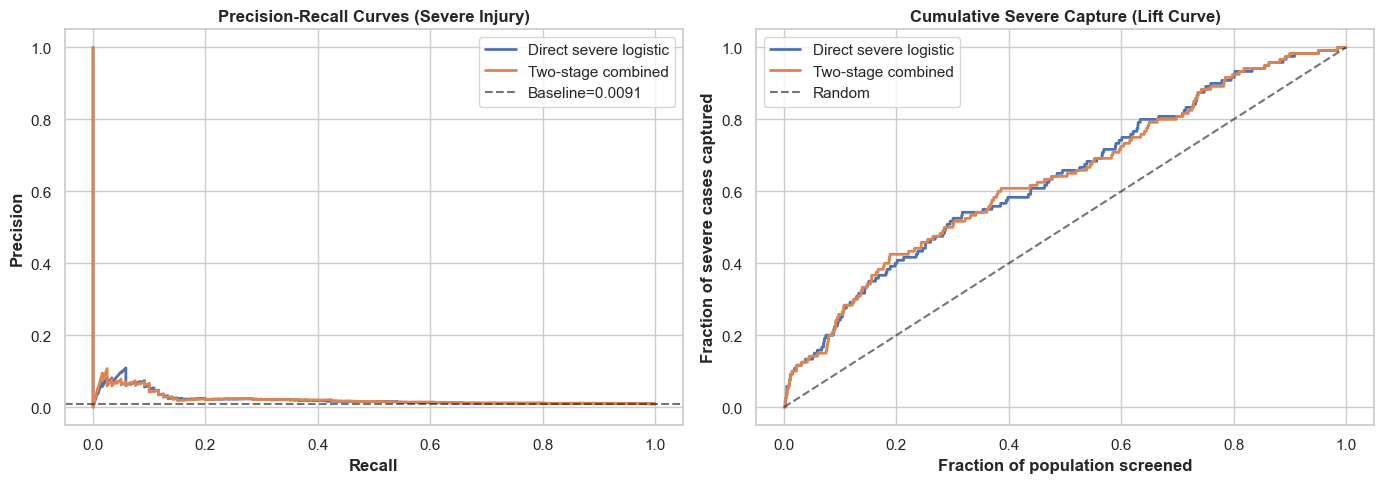

In [285]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve

sns.set_theme(style='whitegrid')

# PR curves for severe target
prec_d, rec_d, _ = precision_recall_curve(y_sev_test_a, p_test_direct)
prec_t, rec_t, _ = precision_recall_curve(y_sev_test_a, p_test_two_stage)
base = np.mean(y_sev_test_a)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(rec_d, prec_d, label='Direct severe logistic', linewidth=2)
axes[0].plot(rec_t, prec_t, label='Two-stage combined', linewidth=2)
axes[0].axhline(base, linestyle='--', color='k', alpha=0.6, label=f'Baseline={base:.4f}')
axes[0].set_title('Precision-Recall Curves (Severe Injury)')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].legend()

# Lift / cumulative capture curve

def cumulative_capture(y_true, p):
    y = np.asarray(y_true)
    o = np.argsort(-np.asarray(p))
    y = y[o]
    cum_pos = np.cumsum(y)
    total_pos = max(cum_pos[-1], 1)
    pop_frac = np.arange(1, len(y) + 1) / len(y)
    cap = cum_pos / total_pos
    return pop_frac, cap

x1, y1 = cumulative_capture(y_sev_test_a, p_test_direct)
x2, y2 = cumulative_capture(y_sev_test_a, p_test_two_stage)

axes[1].plot(x1, y1, label='Direct severe logistic', linewidth=2)
axes[1].plot(x2, y2, label='Two-stage combined', linewidth=2)
axes[1].plot([0,1],[0,1],'k--', alpha=0.6, label='Random')
axes[1].set_title('Cumulative Severe Capture (Lift Curve)')
axes[1].set_xlabel('Fraction of population screened')
axes[1].set_ylabel('Fraction of severe cases captured')
axes[1].legend()

plt.tight_layout()
plt.show()


### 4.7 Sum.md-Aligned Model Upgrade: Elastic-Net + AIC/BIC

This subsection implements exactly what `Sum.md` recommends for binary outcomes:

1. **Logistic Regression** remains primary for interpretation (OR logic).
2. **Regularization** (Elastic Net / LASSO behavior via `l1_ratio`) to improve generalization and stability.
3. **Model comparison** with likelihood-based criteria (**AIC/BIC**) in addition to predictive metrics.
4. **Random Forest** remains a nonlinear baseline (already included above).


In [286]:
from sklearn.base import clone

# Use the section-4 severe target setup
# Expected available objects from earlier cells: X_train, X_test, y_train, y_test, cat_cols, num_cols

pre_en = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", make_ohe())]), cat_cols),
])

# Validation split for hyperparameter selection
X_fit_en, X_val_en, y_fit_en, y_val_en = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

C_grid = [0.03, 0.1, 0.3, 1.0]
l1_grid = [0.0, 0.3, 0.5, 0.7, 1.0]  # 0.0 ~ ridge, 1.0 ~ lasso

rows = []
best = None
best_score = (-1.0, 1e9)  # (PR-AUC high, log-loss low)

for C in C_grid:
    for l1r in l1_grid:
        model = Pipeline([
            ("pre", clone(pre_en)),
            ("clf", LogisticRegression(
                penalty='elasticnet',
                l1_ratio=l1r,
                C=C,
                solver='saga',
                class_weight='balanced',
                max_iter=5000,
                random_state=42,
            )),
        ])
        model.fit(X_fit_en, y_fit_en)
        p_val = model.predict_proba(X_val_en)[:, 1]
        pr = average_precision_score(y_val_en, p_val)
        ll = log_loss(y_val_en, p_val, labels=[0,1])
        ra = roc_auc_score(y_val_en, p_val)
        rows.append({'C': C, 'l1_ratio': l1r, 'val_pr_auc': pr, 'val_roc_auc': ra, 'val_log_loss': ll})

        key = (pr, -ll)
        if key > best_score:
            best_score = key
            best = {'C': C, 'l1_ratio': l1r, 'model': model}

elastic_tuning = pd.DataFrame(rows).sort_values(['val_pr_auc', 'val_log_loss'], ascending=[False, True])
display(elastic_tuning)

print('Best Elastic-Net hyperparameters:', {'C': best['C'], 'l1_ratio': best['l1_ratio']})


c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\liorbj\AppData\Local\anaco

,C,l1_ratio,val_pr_auc,val_roc_auc,val_log_loss
15,1.00,0.0,0.021083,0.686564,0.817526
11,0.30,0.3,0.020952,0.685849,0.989003
13,0.30,0.7,0.020947,0.686025,0.673035
17,1.00,0.5,0.020946,0.685547,0.245254
7,0.10,0.5,0.020912,0.685640,1.037652
18,1.00,0.7,0.020903,0.684060,0.656466
9,0.10,1.0,0.020888,0.685525,0.458918
19,1.00,1.0,0.020827,0.685822,0.363485
16,1.00,0.3,0.020805,0.686575,0.428866
5,0.10,0.0,0.020715,0.684407,0.624866


Best Elastic-Net hyperparameters: {'C': 1.0, 'l1_ratio': 0.0}


In [287]:
# Fit best elastic-net on full train and evaluate on test
elastic_best = Pipeline([
    ("pre", clone(pre_en)),
    ("clf", LogisticRegression(
        penalty='elasticnet',
        l1_ratio=best['l1_ratio'],
        C=best['C'],
        solver='saga',
        class_weight='balanced',
        max_iter=5000,
        random_state=42,
    )),
])
elastic_best.fit(X_train, y_train)
p_test_en = elastic_best.predict_proba(X_test)[:, 1]

# Threshold selection with same precision-floor protocol
thr_en_df = threshold_grid_metrics(y_val_en, best['model'].predict_proba(X_val_en)[:,1], np.linspace(0.005, 0.80, 250))
en_t, en_rule, _ = choose_threshold_with_precision_floor(thr_en_df, precision_floor=0.03)

en_prob_metrics = pd.DataFrame([
    {'model': 'Elastic-Net logistic', **binary_metrics(y_test, p_test_en, threshold=0.5)}
]).set_index('model')
display(en_prob_metrics)


def op_metrics_local(y_true, p, t):
    y_hat = (p >= t).astype(int)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_hat, average='binary', zero_division=0)
    return {'threshold': float(t), 'precision': float(pr), 'recall': float(rc), 'f1': float(f1), 'alert_rate': float(np.mean(y_hat))}


en_oper = pd.DataFrame([
    {'model': 'Elastic-Net logistic', **{
        'threshold': en_t,
        **{k: v for k,v in op_metrics_local(y_test, p_test_en, en_t).items() if k != 'threshold'},
        'threshold_rule': en_rule,
    }}
]).set_index('model')
display(en_oper)

print('Chosen threshold (Elastic-Net):', round(en_t, 4), '|', en_rule)


c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,roc_auc,pr_auc,brier,log_loss,precision@0.5,recall@0.5,f1@0.5,alert_rate@0.5
model,,,,,,,,
Elastic-Net logistic,0.642521,0.020786,0.009112,0.328441,0.0,0.0,0.0,0.0


,threshold,precision,recall,f1,alert_rate,threshold_rule
model,,,,,,
Elastic-Net logistic,0.793614,0.0,0.0,0.0,0.0,max recall with precision >= 0.020


Chosen threshold (Elastic-Net): 0.7936 | max recall with precision >= 0.020


In [288]:
# AIC/BIC comparison across logistic specifications (likelihood-based model selection)
# Build train/validation split for fair predictive comparison of specifications
X_fit_sm, X_val_sm, y_fit_sm, y_val_sm = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

specs = {
    'Spec_A_numeric_only': ['VehicleAge', 'SpeedLimitClean', 'CrashYear', 'SubstanceFlag', 'DistractedFlag', 'VehicleAgeMissing', 'SpeedMissing'],
    'Spec_B_numeric_plus_core_context': ['VehicleAge', 'SpeedLimitClean', 'CrashYear', 'SubstanceFlag', 'DistractedFlag', 'VehicleAgeMissing', 'SpeedMissing', 'WeatherGroup', 'LightGroup', 'TrafficGroup', 'HourBin'],
    'Spec_C_full_current': num_cols + cat_cols,
}

spec_rows = []
for name, cols in specs.items():
    tr = X_fit_sm[cols].copy()
    va = X_val_sm[cols].copy()

    num_part = [c for c in cols if c in num_cols]
    cat_part = [c for c in cols if c in cat_cols]

    if len(num_part) > 0:
        med = tr[num_part].median(numeric_only=True)
        for c in num_part:
            tr[c] = pd.to_numeric(tr[c], errors='coerce').fillna(med[c])
            va[c] = pd.to_numeric(va[c], errors='coerce').fillna(med[c])

    for c in cat_part:
        tr[c] = tr[c].fillna('Missing/Unknown').astype(str)
        va[c] = va[c].fillna('Missing/Unknown').astype(str)

    tr_dm = pd.get_dummies(tr, columns=cat_part, drop_first=True, dtype=float)
    va_dm = pd.get_dummies(va, columns=cat_part, drop_first=True, dtype=float)
    va_dm = va_dm.reindex(columns=tr_dm.columns, fill_value=0.0)

    tr_dm = sm.add_constant(tr_dm, has_constant='add')
    va_dm = sm.add_constant(va_dm, has_constant='add')

    fit = sm.GLM(y_fit_sm, tr_dm, family=sm.families.Binomial()).fit()
    p_va = fit.predict(va_dm)

    llf = float(fit.llf)
    k = int(fit.df_model) + 1  # + intercept
    n = int(fit.nobs)
    aic_manual = -2 * llf + 2 * k
    bic_manual = -2 * llf + k * np.log(max(n, 1))

    spec_rows.append({
        'spec': name,
        'n_params': k,
        'llf': llf,
        'AIC': aic_manual,
        'BIC': bic_manual,
        'val_pr_auc': float(average_precision_score(y_val_sm, p_va)),
        'val_roc_auc': float(roc_auc_score(y_val_sm, p_va)),
        'val_log_loss': float(log_loss(y_val_sm, p_va, labels=[0,1])),
    })

spec_cmp = pd.DataFrame(spec_rows).sort_values(['AIC', 'BIC'])
display(spec_cmp)

print('Best by AIC:', spec_cmp.iloc[0]['spec'])
print('Best by BIC:', spec_cmp.sort_values('BIC').iloc[0]['spec'])


,spec,n_params,llf,AIC,BIC,val_pr_auc,val_roc_auc,val_log_loss
2,Spec_C_full_current,35,-1951.029228,3972.058456,4272.503958,0.023871,0.698067,0.049477
1,Spec_B_numeric_plus_core_context,20,-1971.873348,3983.746696,4155.429840,0.022980,0.682857,0.049791
0,Spec_A_numeric_only,8,-1984.123555,3984.247110,4052.920368,0.024354,0.668834,0.049824


Best by AIC: Spec_C_full_current
Best by BIC: Spec_A_numeric_only


#### 4.7.1 Practical Selection Rule for This Project

Use this rule in the report:
1. Keep **interpretable logistic OR table** for explanatory findings.
2. Use **Elastic-Net logistic** if it improves PR-AUC / calibration with similar or better operating metrics.
3. Use **AIC/BIC table** to justify chosen feature specification (course-aligned likelihood criteria).
4. Keep **Random Forest** as nonlinear baseline for robustness check.
5. For count data, keep Poisson/NB section with overdispersion diagnostics.


## 5. Conclusion
Summarize key patterns from the results (hotspots, time patterns, driver/vehicle factors, environment, vehicle conditions).
Limitations: The dataset covers crashes only (no exposure data), includes missing/unknown values, and may contain reporting inconsistencies.
Future work: Add exposure data (traffic volume), expand geography, and perform more rigorous causal analysis.
